In [3]:
from asyncio.windows_events import NULL
import os
from PIL.Image import ID
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
#import PlottingFunctions as pf
from mpl_toolkits.mplot3d import Axes3D
from tqdm.auto import tqdm
from time import perf_counter
# %matplotlib widget

plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (14,10)

In [4]:
def llist_to_str(llist):
    str_ = []
    for list_ in llist:
        str_.append(str(list_))
    return np.array(str_)

def load_object(filename):
    '''
    load an object from a file using the built-in pickle library

    :param filename: Name of the file from which to load data
    '''
    try:
        with open(filename, "rb") as f:
            return pickle.load(f)
    except Exception as ex:
        print("Error during unpickling object (Possibly unsupported):", ex)

def pad_to_length(short_arr, target_length):
    """
    Given short_arr of shape (m, d), return a new array of shape (target_length, d)
    whose first (target_length - m) rows are NaN and whose last m rows are short_arr.
    """
    m, d = short_arr.shape
    if m == target_length:
        return short_arr.copy()
    elif m > target_length:
        raise ValueError(f"short_arr has more rows ({m}) than target_length ({target_length}).")
    # create a (target_length, d) array full of NaNs
    padded = np.full((target_length, d), np.nan, dtype=short_arr.dtype)
    # put the original data into the last m rows
    padded[-m :, :] = short_arr
    return padded

In [5]:
def XYZoverTime(pos_r, pos_i, pos_p, labels=['real', 'integral', 'prediction'], marker=['b-', 'r--', 'g,']):
    #plt.rcParams["figure.figsize"] = (14,10)
    plt.subplot(3,1,1)
    plt.plot(pos_r[:,0], marker[0], label=labels[0])
    plt.plot(pos_i[:,0], marker[1], label=labels[1])
    plt.plot(pos_p[:,0], marker[2], label=labels[2])
    plt.legend()
    plt.ylabel('X')
    plt.grid()
    plt.subplot(3,1,2)
    plt.plot(pos_r[:,1], marker[0], label=labels[0])
    plt.plot(pos_i[:,1], marker[1], label=labels[1])
    plt.plot(pos_p[:,1], marker[2], label=labels[2])
    plt.legend()
    plt.ylabel('Y')
    plt.grid()
    plt.subplot(3,1,3)
    plt.plot(pos_r[:,2], marker[0], label=labels[0])
    plt.plot(pos_i[:,2], marker[1], label=labels[1])
    plt.plot(pos_p[:,2], marker[2], label=labels[2])
    plt.legend()
    plt.ylabel('Z')
    plt.xlabel('t')
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'Results\\XYZpredictionProjected.png', format='png')
    plt.show()

def XYoverTime(pos_r, pos_i, pos_p, labels=['real', 'integral', 'prediction'], marker=['b-', 'r--', 'g,']):
    #plt.rcParams["figure.figsize"] = (14,10)
    plt.subplot(2,1,1)
    plt.plot(pos_r[:,0], marker[0], label=labels[0])
    plt.plot(pos_i[:,0], marker[1], label=labels[1])
    plt.plot(pos_p[:,0], marker[2], label=labels[2])
    plt.legend()
    plt.ylabel('X')
    plt.grid()
    plt.subplot(2,1,2)
    plt.plot(pos_r[:,1], marker[0], label=labels[0])
    plt.plot(pos_i[:,1], marker[1], label=labels[1])
    plt.plot(pos_p[:,1], marker[2], label=labels[2])
    plt.legend()
    plt.ylabel('Y')
    plt.grid()
    plt.legend()
    plt.xlabel('t')
    plt.tight_layout()
    plt.savefig(f'Results\\XYprediction.png', format='png')
    plt.show()

def plot_rolling_timeseries_stats(real, predictions, window_size=200):
    """
    Plot time series for x, y, z coordinates with rolling mean and standard deviation.
    
    Parameters:
    - predictions: NumPy array of shape (n_timesteps, 3)
    - window_size: Size of the rolling window for calculating mean and std dev
    """
    # Create a figure with 3 subplots (one for each coordinate)
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    coordinates = ['X', 'Y', 'Z']
    
    for i in range(3):
        # Extract the i-th coordinate
        coord_data = predictions[:, i]
        
        # Calculate rolling mean and standard deviation using pandas-like method
        rolling_mean = np.zeros_like(coord_data)
        rolling_std = np.zeros_like(coord_data)
        
        for j in range(len(coord_data)):
            # Determine the window boundaries
            start = max(0, j - window_size // 2)
            end = min(len(coord_data), j + window_size // 2)
            
            # Calculate local statistics
            window_data = coord_data[start:end]
            rolling_mean[j] = np.mean(window_data)
            rolling_std[j] = np.std(window_data)
        
        # Plot the original time series
        axes[i].plot(np.arange(len(coord_data)), coord_data, 'g,', label='Predictions')
        axes[i].plot(np.arange(len(coord_data)), real[:, i], 'r-', label='Actual')
        
        
        # Plot the rolling mean line
        axes[i].plot(np.arange(len(coord_data)), rolling_mean, color='blue', linestyle='--', 
                     label=f'Mean (window={window_size})')
        
        # Add rolling standard deviation shading
        axes[i].fill_between(np.arange(len(coord_data)), 
                             rolling_mean - rolling_std, 
                             rolling_mean + rolling_std, 
                             color='cyan', alpha=1, 
                             label='±1 std dev')
        
        # Customize the plot
        axes[i].set_ylabel(f'{coordinates[i]} Coordinate')
        axes[i].legend()
        axes[i].grid(True, linestyle='--', alpha=0.5)
    
    axes[-1].set_xlabel('Time Steps')
    plt.tight_layout()
    plt.show()

def prediction_path_projected(path, path_pred, mse, ID=0):
    stop = int(len(path))
    stop = np.clip(stop, 10, 40000)
    
    x, y, z = path[:,0], path[:,1], path[:,2] 
    x_pred, y_pred, z_pred = path_pred[:,0], path_pred[:,1], path_pred[:,2] 
    x_min, y_min, z_min = np.min(x), np.max(y), np.min(z) # the y-axis is weird like that

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot x and y axes on z.
    ax.plot(x[:stop], y[:stop], 'b-', zs=z_min, zdir='z', label='path in (x, y)')
    ax.plot(x_pred[:stop], y_pred[:stop], 'c,', zs=z_min, zdir='z', label='prediction in (x, y)')
    
    ax.plot(x[:stop], z[:stop], 'r-', zs=y_min, zdir='y', label='path in (x, z)')
    ax.plot(x_pred[:stop], z_pred[:stop], 'm,' ,zs=y_min, zdir='y', label='prediction in (x, z)')
    
    ax.plot(y[:stop], z[:stop], 'g-', zs=x_min, zdir='x', label='path in (y, z)')
    ax.plot(y_pred[:stop], z_pred[:stop], 'y,', zs=x_min, zdir='x', label='prediction in (y, z)')

    # Make legend, set axes limits and labels
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Integrated vs Predicted Path. First {stop} iterations. Mean MSE = {np.mean(mse)}')
    
    # Customize the view angle so it's easier to see that the scatter points lie
    # on the plane y=0
    #ax.view_init(elev=20., azim=-35, roll=0)
    plt.tight_layout()
    # Save and show the figure
    plt.show()
    plt.savefig(f'Results\\ID {ID}\\predictionProjected.png', format='png')
    plt.close()

In [6]:
def plot_frame_figure(gains, positions_array, network_activity, num_bins=50, neuron=42, ID=0, subID=None):
    """
    Plots a heatmap of network activity at different gain levels and overlays the trajectory. 
    The plot is saved in the results folder within the relative directory.

    :param positions_array: list of shape (ntime, ndim) 
    :param num_bins: int 
    :param network_activity: list of shape (ntime, ngain, nneuron)
    :param neuron: int. Default=42
    """
    x_min, y_min = np.min(positions_array, axis=0)
    x_max, y_max = np.max(positions_array, axis=0)

    fig = plt.figure(figsize=(8, 4))
    gs = fig.add_gridspec(2, len(gains)+1) 

    # Adding subplots to the gridspec
    for a, alpha in enumerate(gains):

        heatmap_ax = fig.add_subplot(gs[0, a])
        heatmap_ax.set_aspect('equal')

        # Initialize an empty heatmap
        x_bins = np.linspace(x_min, x_max,num_bins)
        y_bins = np.linspace(y_min, y_max,num_bins)
        heatmap = np.zeros((num_bins, num_bins))

        # Iterate over positions and network_activity (Over time)
        for position, activity in zip(positions_array, network_activity):
            x_index = np.digitize(position[0], x_bins) - 1
            y_index = np.digitize(position[1], y_bins) - 1
            heatmap[x_index, y_index] = max(heatmap[x_index, y_index], np.mean(activity[a, neuron]))
            #                                 Activity is of shape (ngains, neurons) here  ^^ pick any neuron

        im = heatmap_ax.imshow(heatmap.T, origin='lower', extent=[x_min, x_max, y_min, y_max], vmax=1, vmin=0)
        heatmap_ax.set(title=f'Gain = {round(alpha, 2)}', xticks=[], yticks=[])

    # # add subplot for colorbar (there is sth odd here, max fr is a bit above 1 and not 1)
    cbar_ax = fig.add_subplot(gs[0, -1])  # Spanning the last column
    colorbar = fig.colorbar(im, cax=cbar_ax)
    colorbar.set_label('Normalized firing rate', labelpad=15, rotation=270)
    colorbar.set_ticks([0, 0.5, 1])  # Set ticks at min, mid, and max values
    colorbar.set_ticklabels([f'{0:.2f}', f'{0.5:.2f}', f'{1:.2f}'])  # Set tick labels

    positions_array = np.array(positions_array) # enable numpy slicing      
    trajectory_ax = fig.add_subplot(gs[1, 1:len(gains)])  # Adding subplot for the bottom row
    trajectory_ax.plot(positions_array[:, 0], positions_array[:, 1], alpha=0.7, color='purple')
    trajectory_ax.set_title('Effective Arena with travelled path', fontsize=20)
    trajectory_ax.set_aspect('equal')


    fig.tight_layout(h_pad=3.0) # Adjust layout # change spacing between plots
    if subID is None:
        path = f'Results\\ID {ID}\\result_activity_figure.png'
    else:
        path = f'Results\\ID {ID}\\activity_{subID}.png'
    plt.savefig(path, format='png') # save in relative folder Results in Source/Repos/SelfLocalisationCF
    #plt.show()
    #plt.close()

def plot_modular_activity(prj_op, pos, ac, gains, ID, projection):
    pos2d = np.einsum('mnx, tx->mtn', prj_op, pos)
    abc = np.array(['X', 'Y', 'Z'])
    for i, p in enumerate(pos2d):
        print(f'Projection in {abc[projection[i]]}')
        plot_frame_figure(gains, p, ac[:,i], ID=ID, subID=f'mod{i}', neuron=24)


# Addendum Analysis

## Making a 3d activity blob

In [24]:
name = f'Benchmark activity Setting 0of2'
filename = f'Results\\ID {name}\\summary.pickle'
data = load_object(filename)
#print(f'Reading from file : {filename}')
mse_on = data['avg online mse']
std_on = data['std online mse']
per_on = data['per online mse']
mse_onSh = data['avg online short mse']
std_onSh = data['std online short mse']
per_onSh = data['per online short mse']
mse_of = data['avg offline mse']
std_of = data['std offline mse']
per_of = data['per offline mse']
mse_ofSh = data['avg offline mse short']
std_ofSh = data['std offline mse short']
per_ofSh = data['per offline mse short']
cov_100 = data['avg coverage']
iqr_cov_100 = data['per coverage']
cov_80 = data['avg coverage train']
iqr_cov_80 = data['per coverage train']
    
gains = data['setting var']
mse = [mse_on, mse_of, mse_onSh, mse_ofSh]
std = [std_on, std_of, std_onSh, std_ofSh]
per = [per_on, per_of, per_onSh, per_ofSh]
labels = ['RLS 100', 'RR 100', 'RLS 80', 'RR 80']

filename = f'Results\\ID {name}\\data trial0.pickle'
data = load_object(filename)

time = data['sim time']
activity = np.array(data['activity'])
pos_i = np.array(data['position internal'])
pos_pon100 = np.array(data['online prediction'])
pos_pof100 = np.array(data['offline prediction'])

pos_labels = ['Internal', 'RLS 100', 'RR 100']

In [37]:
def plot_modular_activity(prj_op, pos, ac, gains, ID, projection):
    pos2d = np.einsum('mnx, tx->mtn', prj_op, pos)
    abc = np.array(['X', 'Y', 'Z'])
    for i, p in enumerate(pos2d):
        print(f'Projection in {abc[projection[i]]}')
        plot_frame_figure(gains, p, ac[:,i], ID=ID, subID=f'mod{i}', neuron=24)

In [ ]:
prj_op = np.array(data['module operators'])
pos = np.array(data['']
plot_modular_activity()

# Animating 2D Trajectory

Saving animation as GIF...
Animation saved as 'trajectory_animation.gif'


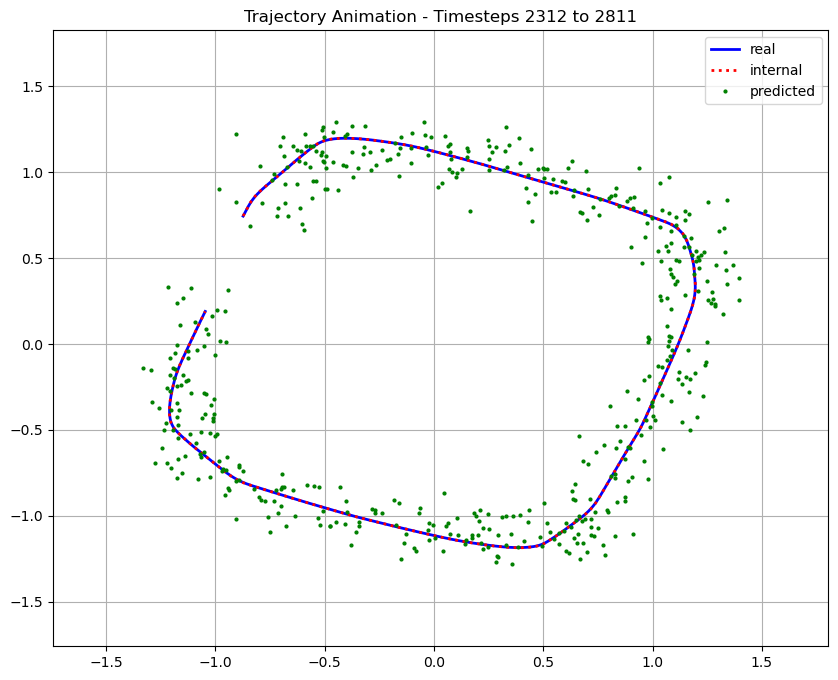

In [88]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Configuration
window_size = 500  # Number of timesteps to show at once
data_length = int(len(pos_r)/10)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))
ax.grid(True)

# Initialize empty line objects
line_real, = ax.plot([], [], 'b-', label='real', linewidth=2)
line_internal, = ax.plot([], [], 'r:', label='internal', linewidth=2)
line_predicted, = ax.plot([], [], 'g.', label='predicted', markersize=4)

# Set axis limits based on the full dataset
all_x = np.concatenate([pos_r[:, 0], pos_i[:, 0], pos_p[:, 0]])
all_y = np.concatenate([pos_r[:, 1], pos_i[:, 1], pos_p[:, 1]])
margin = 0.1 * max(all_x.max() - all_x.min(), all_y.max() - all_y.min())
ax.set_xlim(all_x.min() - margin, all_x.max() + margin)
ax.set_ylim(all_y.min() - margin, all_y.max() + margin)
ax.legend()

def animate(frame):
    # Calculate the current window
    start_idx = frame
    end_idx = min(start_idx + window_size, data_length)
    
    # Update the data for each line
    line_real.set_data(pos_r[start_idx:end_idx, 0], pos_r[start_idx:end_idx, 1])
    line_internal.set_data(pos_i[start_idx:end_idx, 0], pos_i[start_idx:end_idx, 1])
    line_predicted.set_data(pos_p[start_idx:end_idx, 0], pos_p[start_idx:end_idx, 1])
    
    # Update the title to show current frame info
    ax.set_title(f'Trajectory Animation - Timesteps {start_idx} to {end_idx-1}')
    
    return line_real, line_internal, line_predicted

# Calculate number of frames (slide window one step at a time until we reach the end)
num_frames = max(1, data_length - window_size + 1)

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=num_frames, 
                             interval=100, blit=True, repeat=True)

# Save as GIF (using Pillow writer explicitly)
print("Saving animation as GIF...")
Writer = animation.writers['pillow']
writer = Writer(fps=30, metadata=dict(artist='matplotlib'), bitrate=1800)
anim.save('trajectory_animation.gif', writer=writer, dpi=100)
print("Animation saved as 'trajectory_animation.gif'")

# Display the animation (optional - comment out if you only want to save)
#plt.show()

# Analysis of multitrial benchmarks

In [72]:
settings = 7
mse_on = np.zeros(settings)
iqr_on = np.zeros((settings, 2))
mse_onSh = np.zeros(settings)
iqr_onSh = np.zeros((settings, 2))
mse_of = np.zeros(settings)
iqr_of = np.zeros((settings, 2))
mse_ofSh = np.zeros(settings)
iqr_ofSh = np.zeros((settings, 2))
cov = np.zeros(settings)
cov_iqr = np.zeros((settings, 2))
cov_test = np.zeros(settings)
cov_iqr_test = np.zeros((settings, 2))

for i in range(settings):
    name = f'Benchmark 3D Noise setting {i}of{settings}'
    filename = f'Results\\ID {name}\\summary.pickle'
    data = load_object(filename)
        
    mse_on[i] = data['avg online mse']
    iqr_on[i] = data['per online mse']
    mse_onSh[i] = data['avg online short mse']
    iqr_onSh[i] = data['per online short mse']
    mse_of[i] = data['avg offline mse']
    iqr_of[i] = data['per offline mse']
    mse_ofSh[i] = data['avg offline mse short']
    iqr_ofSh[i] = data['per offline mse short']
    cov[i] = data['avg coverage']
    cov_iqr[i] = data['per coverage']
    cov_test[i] = data['avg coverage train']
    cov_iqr_test[i] = data['per coverage train']

    #print(f'{name} time = {time[i]}')
    #print(f' online trained  : {np.mean(mse_on[i]):.3} +- {std_on[i]:.3}')
    #print(f' online test     : {np.mean(mse_onSh[i]):.3} +- {std_onSh[i]:.3}')
    #print(f' offline trained : {mse_of[i]:.3} +- {std_of[i]:.3}')
    #print(f' offline test    : {mse_ofSh[i]:.3} +- {std_ofSh[i]:.3}')
time = data['setting var']

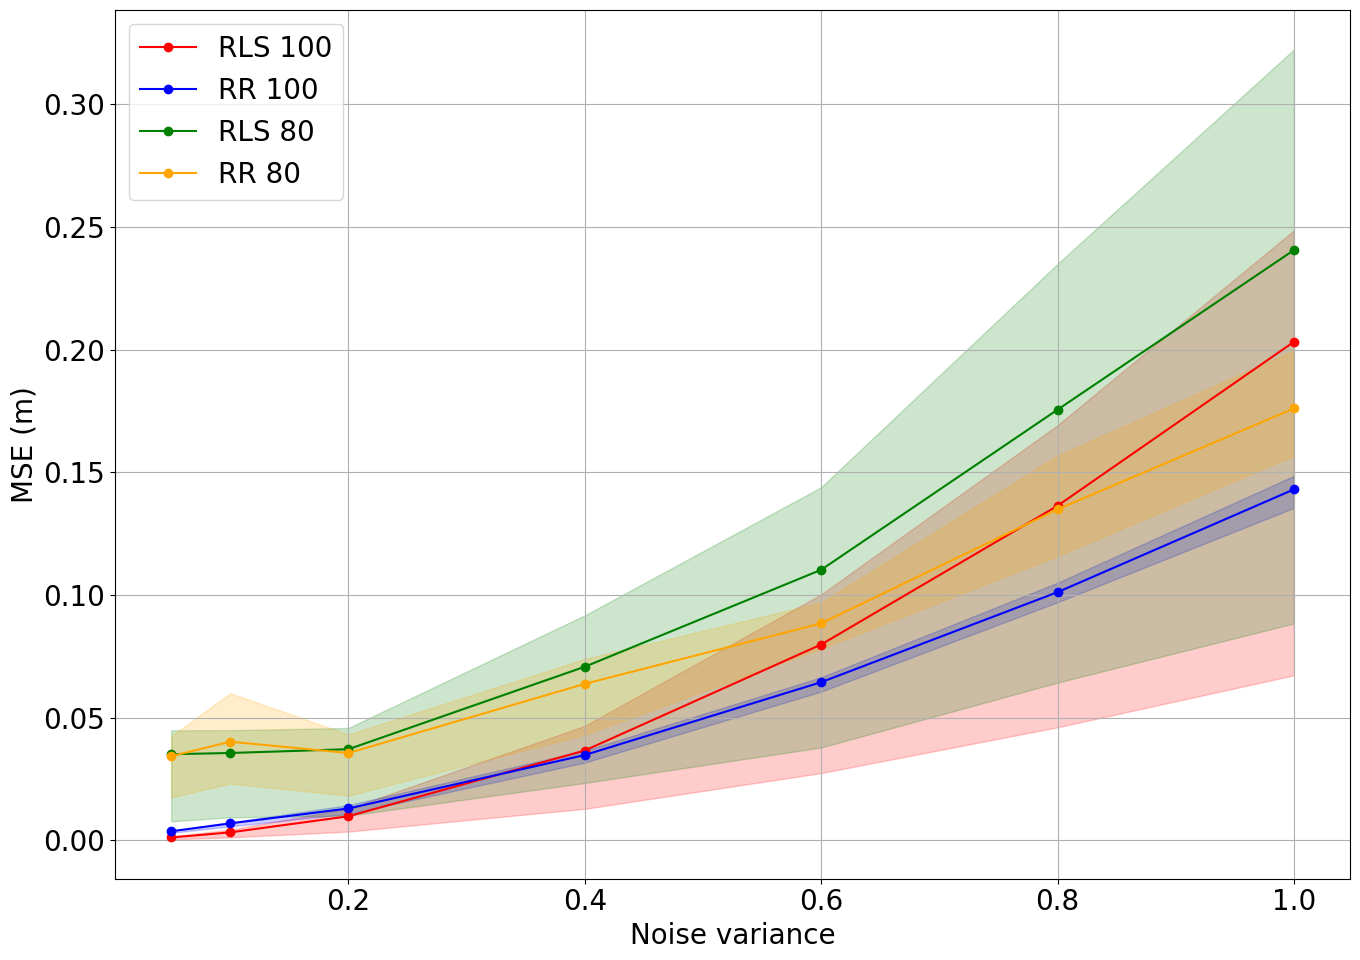

In [77]:
#plt.subplot(2,1,1)
plt.plot(time, mse_on, 'r-o', label='RLS 100')
plt.fill_between(time, iqr_on[:,0], iqr_on[:,1], color='red', alpha=0.2)
plt.plot(time, mse_of, 'b-o', label='RR 100')
plt.fill_between(time, iqr_of[:,0] , iqr_of[:,1], color='blue', alpha=0.2)
#plt.grid()
#plt.legend()
#plt.ylabel('MSE')
#plt.xlabel('Noise variance')
#plt.ylim((0, 0.0015))
#plt.subplot(2,1,2)
plt.plot(time, mse_onSh,'g-o', label='RLS 80')
plt.fill_between(time, iqr_onSh[:,0], iqr_onSh[:,1], color='green', alpha=0.2)
plt.plot(time, mse_ofSh, color='orange', marker='o', label='RR 80')
plt.fill_between(time, iqr_ofSh[:,0], iqr_ofSh[:,1], color='orange', alpha=0.2)
#plt.ylim((0, 0.05))
plt.grid()
plt.legend()
plt.ylabel('MSE (m)')
plt.xlabel('Noise variance')
plt.tight_layout()
plt.savefig(f'NoiseComparison.png', format='png')
plt.show()

In [10]:
settings = 4
mse_on = np.zeros(settings)
iqr_on = np.zeros((settings, 2))
mse_onSh = np.zeros(settings)
iqr_onSh = np.zeros((settings, 2))
mse_of = np.zeros(settings)
iqr_of = np.zeros((settings, 2))
mse_ofSh = np.zeros(settings)
iqr_ofSh = np.zeros((settings, 2))
cov = np.zeros(settings)
cov_iqr = np.zeros((settings, 2))
cov_test = np.zeros(settings)
cov_iqr_test = np.zeros((settings, 2))

for i in range(settings):
    name = f'Benchmark 3D Time setting {i}of{settings}'
    filename = f'Results\\ID {name}\\summary.pickle'
    data = load_object(filename)
        
    mse_on[i] = data['avg online mse']
    iqr_on[i] = data['per online mse']
    mse_onSh[i] = data['avg online short mse']
    iqr_onSh[i] = data['per online short mse']
    mse_of[i] = data['avg offline mse']
    iqr_of[i] = data['per offline mse']
    mse_ofSh[i] = data['avg offline mse short']
    iqr_ofSh[i] = data['per offline mse short']
    cov[i] = data['avg coverage']
    cov_iqr[i] = data['per coverage']
    cov_test[i] = data['avg coverage train']
    cov_iqr_test[i] = data['per coverage train']

    #print(f'{name} time = {time[i]}')
    #print(f' online trained  : {np.mean(mse_on[i]):.3} +- {std_on[i]:.3}')
    #print(f' online test     : {np.mean(mse_onSh[i]):.3} +- {std_onSh[i]:.3}')
    #print(f' offline trained : {mse_of[i]:.3} +- {std_of[i]:.3}')
    #print(f' offline test    : {mse_ofSh[i]:.3} +- {std_ofSh[i]:.3}')
time = data['setting var']

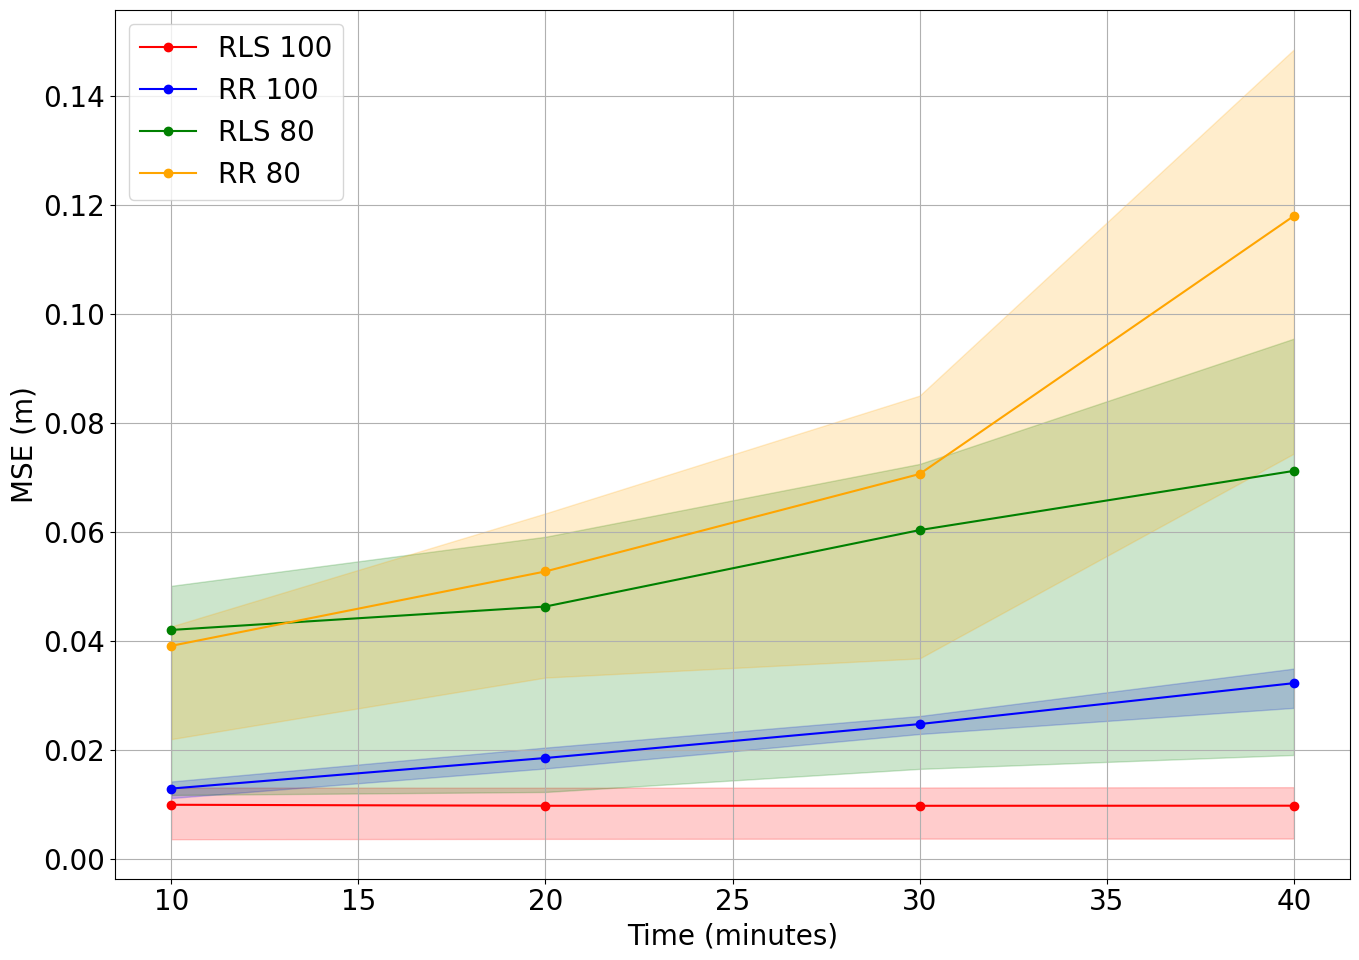

In [79]:
#plt.subplot(2,1,1)
plt.plot(time, mse_on, 'r-o', label='RLS 100')
plt.fill_between(time, iqr_on[:,0], iqr_on[:,1], color='red', alpha=0.2)
plt.plot(time, mse_of, 'b-o', label='RR 100')
plt.fill_between(time, iqr_of[:,0] , iqr_of[:,1], color='blue', alpha=0.2)
#plt.ylim((0, 0.0015))
#plt.subplot(2,1,2)
plt.plot(time, mse_onSh,'g-o', label='RLS 80')
plt.fill_between(time, iqr_onSh[:,0], iqr_onSh[:,1], color='green', alpha=0.2)
plt.plot(time, mse_ofSh, color='orange', marker='o', label='RR 80')
plt.fill_between(time, iqr_ofSh[:,0], iqr_ofSh[:,1], color='orange', alpha=0.2)
#plt.ylim((0, 0.05))
plt.grid()
plt.legend()
plt.ylabel('MSE (m)')
plt.xlabel('Time (minutes)')
plt.tight_layout()
plt.savefig(f'TimeComparison.png', format='png')
plt.show()

### Coverage

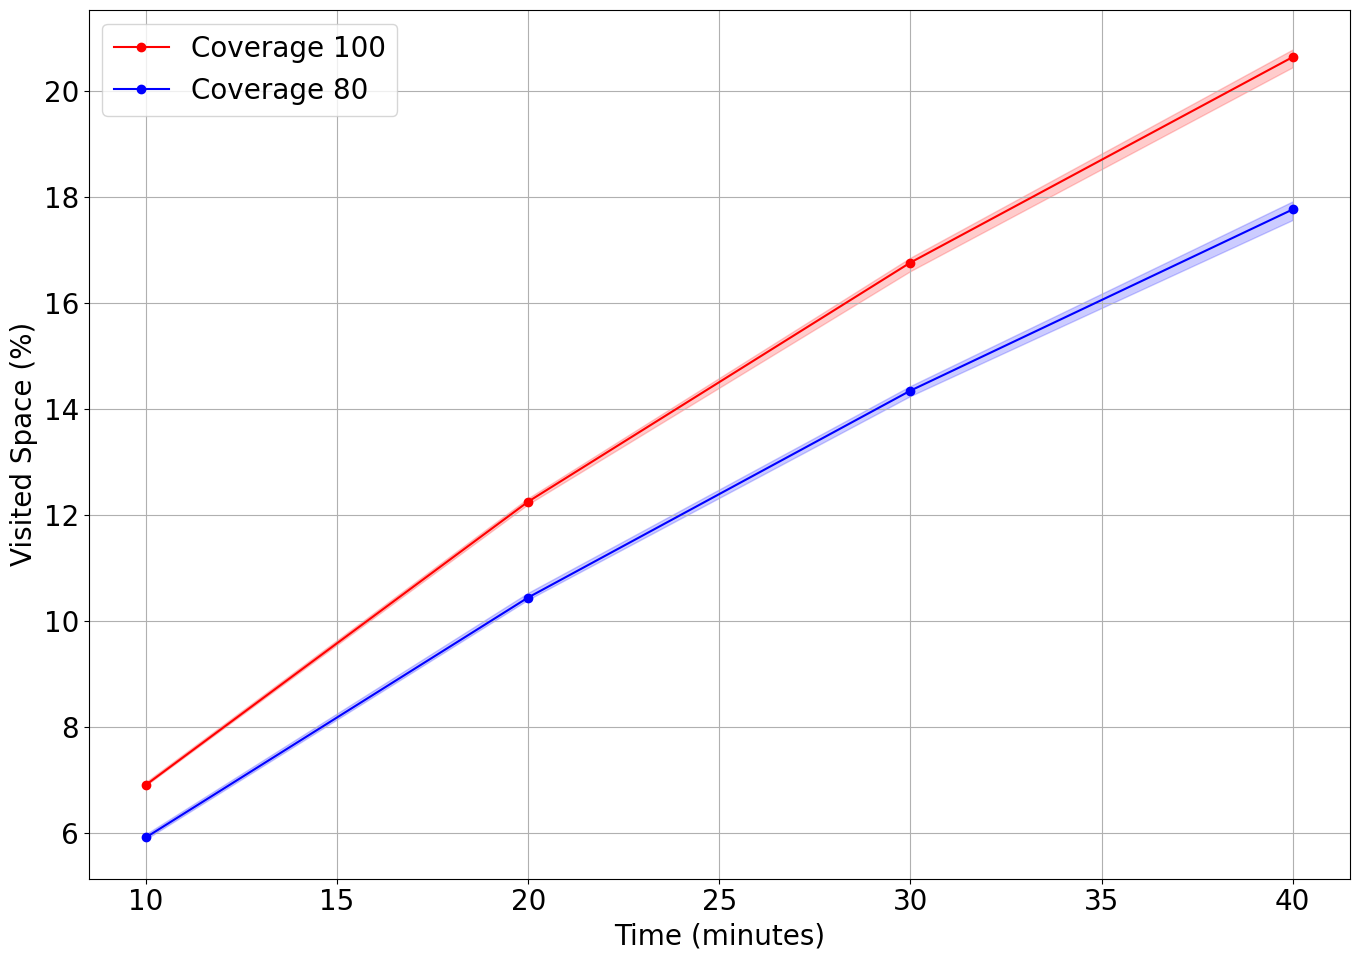

In [11]:
plt.plot(time, cov,'r-o', label='Coverage 100')
plt.fill_between(time, cov_iqr[:,0], cov_iqr[:,1], color='red', alpha=0.2)
plt.plot(time, cov_test, 'b-o', label='Coverage 80')
plt.fill_between(time, cov_iqr_test[:,0], cov_iqr_test[:,1], color='blue', alpha=0.2)
#plt.ylim((0, 0.05))
plt.grid()
plt.legend()
plt.ylabel('Visited Space (%)')
plt.xlabel('Time (minutes)')
plt.tight_layout()
plt.savefig(f'Coverage 3D.png', format='png')
plt.show()

# Estimate Volume Coverage

In [11]:
coverage_avg = []
coverage_std = []
for i in range(len(noise)):
    name = f'BenchmarkNoise setting{i+1}of{len(noise)}'
    filename = f'Results\\ID {name}\\summary.pickle'
    data = load_object(filename)
    coverage_avg.append(data['avg coverage train'])
    coverage_std.append(data['std coverage train'])

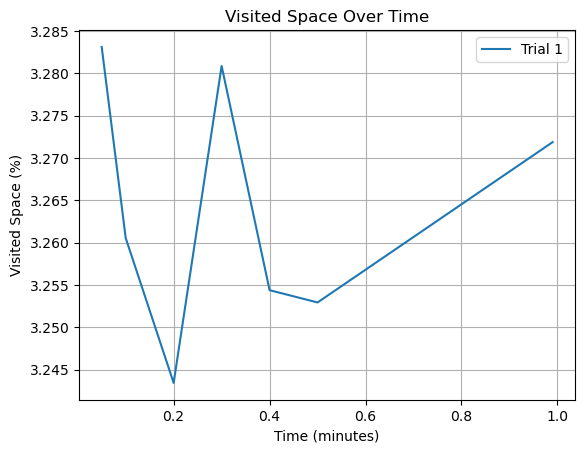

In [30]:
coverage_avg = np.array(coverage_avg)
x_time = np.array(range(len(coverage_avg))) / 32 /60
x_noise = noise

plt.plot(x_noise, coverage_avg, label=f'Trial {i+1}')
plt.xlabel('Time (minutes)')
plt.ylabel('Visited Space (%)')
plt.title('Visited Space Over Time')
plt.grid()
plt.legend()
plt.show()

# Activity functions

# Best Gain Comparison

In [129]:
nr_gains = 16

# Initialize arrays to store results
mse_on = np.zeros(nr_gains)      # Average online MSE
std_on = np.zeros(nr_gains)      # Standard deviation online MSE
per_on = np.zeros((nr_gains, 2))

mse_onSh = np.zeros(nr_gains)    # Average online short MSE
std_onSh = np.zeros(nr_gains)    # Standard deviation online short MSE
per_onSh = np.zeros((nr_gains, 2))

mse_of = np.zeros(nr_gains)      # Average offline MSE
std_of = np.zeros(nr_gains)      # Standard deviation offline MSE
per_of = np.zeros((nr_gains, 2))

mse_ofSh = np.zeros(nr_gains)    # Average offline short MSE
std_ofSh = np.zeros(nr_gains)    # Standard deviation offline short MSE
per_ofSh = np.zeros((nr_gains, 2))

cov_100 = np.zeros(nr_gains)    # Average offline short MSE
iqr_cov_100 = np.zeros((nr_gains, 2))
cov_80 = np.zeros(nr_gains)    # Average offline short MSE
iqr_cov_80 = np.zeros((nr_gains, 2))

for i in range(nr_gains):
    name = f'Benchmark 3D BestGain Setting {i}of{nr_gains}'
    filename = f'Results\\ID {name}\\summary.pickle'
    data = load_object(filename)
    #print(f'Reading from file : {filename}')
        
    mse_on[i] = data['avg online mse']
    std_on[i] = data['std online mse']
    per_on[i] = data['per online mse']
    
    mse_onSh[i] = data['avg online short mse']
    std_onSh[i] = data['std online short mse']
    per_onSh[i] = data['per online short mse']
    
    mse_of[i] = data['avg offline mse']
    std_of[i] = data['std offline mse']
    per_of[i] = data['per offline mse']
    
    mse_ofSh[i] = data['avg offline mse short']
    std_ofSh[i] = data['std offline mse short']
    per_ofSh[i] = data['per offline mse short']
    
    cov_100[i] = data['avg coverage']
    iqr_cov_100[i] = data['per coverage']
    cov_80[i] = data['avg coverage train']
    iqr_cov_80[i] = data['per coverage train']

    #filename = f'Results\\ID {name}\\data trial0.pickle'
    #data = load_object(filename)
    
gains = data['setting var']
mse = [mse_on, mse_of, mse_onSh, mse_ofSh]
std = [std_on, std_of, std_onSh, std_ofSh]
per = [per_on, per_of, per_onSh, per_ofSh]
labels = ['RLS 100', 'RR 100', 'RLS 80', 'RR 80']

In [11]:
def llist_to_str(llist):
    str_ = []
    for list_ in llist:
        str_.append(str(list_))
    return np.array(str_)

In [49]:
a = llist_to_str(gains)

In [68]:
# Alternative: Single plot focusing on MSE with interquartile bands
def plot_mse_with_bands(mse_data, iqr_data, gains, decoder_names=None):
    """
    Create a focused plot showing MSE with confidence bands.
    """
    if decoder_names is None:
        decoder_names = [f'Decoder {i+1}' for i in range(4)]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    colors = ['b', 'g', 'r', 'orange']
    
    for i in range(4):
        # Plot main line
        ax.plot(gains, mse_data[i], color=colors[i], linewidth=2.5, 
                label=decoder_names[i], marker='o', markersize=6)
        
        # Add confidence band (mean ± std)
        ax.fill_between(gains, 
                       iqr_data[i][:,0], 
                       iqr_data[i][:,1], 
                       color=colors[i], alpha=0.2)
    
    ax.set_xlabel('Gain Configuration')
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_ylabel('MSE +- interquartile range')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Highlight best performing regions
    avg_mse = np.sum(mse_data, axis=0)
    sorted_indices = np.argsort(avg_mse)
    
    best_idx = sorted_indices[0]
    second_best_idx = sorted_indices[1]
    
    # Plot best performance
    ax.axvline(x=gains[best_idx], color='black', linestyle='--', alpha=0.7, 
               label='Best avg.')
    
    # Plot second best performance
    ax.axvline(x=gains[second_best_idx], color='grey', linestyle='--', alpha=0.7, 
               label='2nd best avg.')
    
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))    
    plt.tight_layout()
    return fig

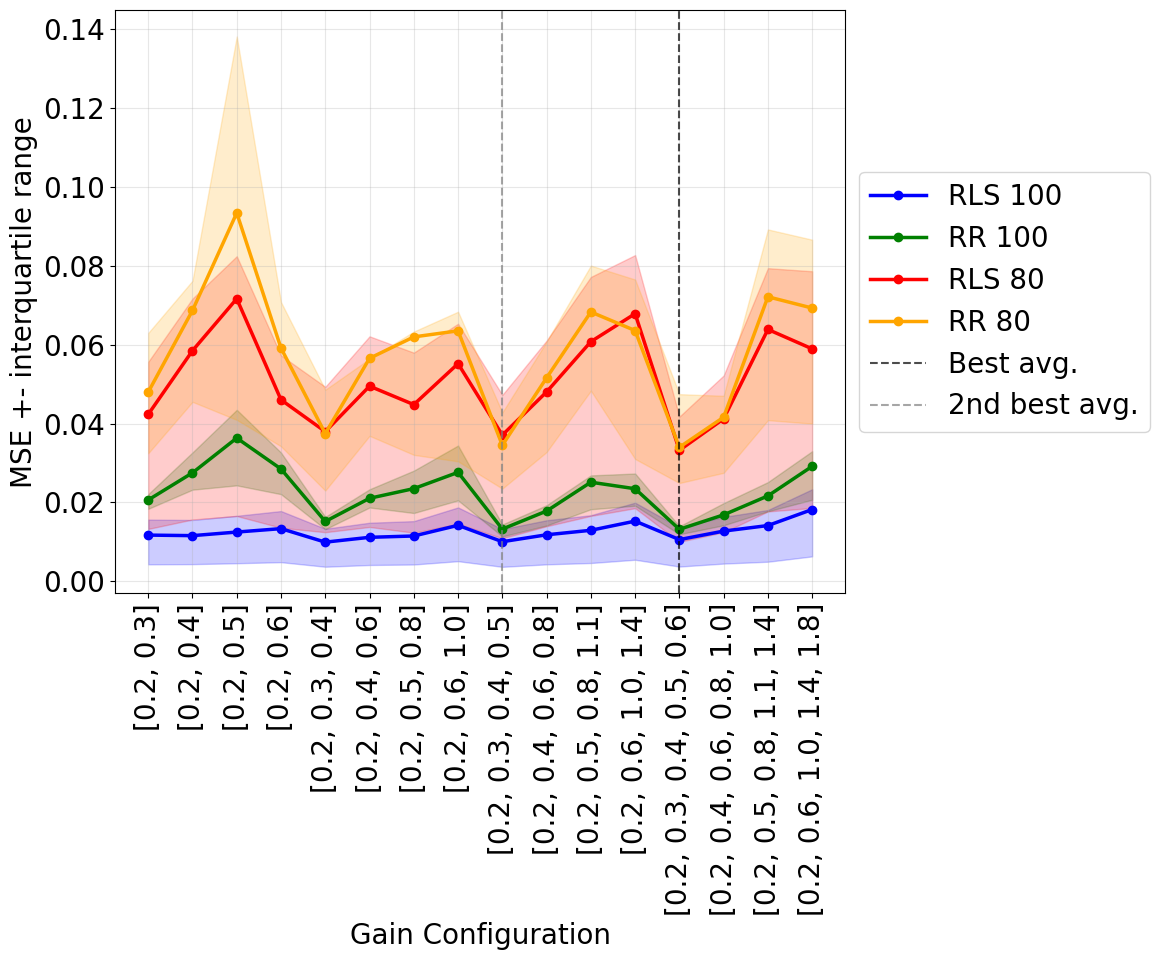

In [71]:
fig1 = plot_mse_with_bands(mse, per, a, labels)
plt.savefig('3D Gain Comparison')

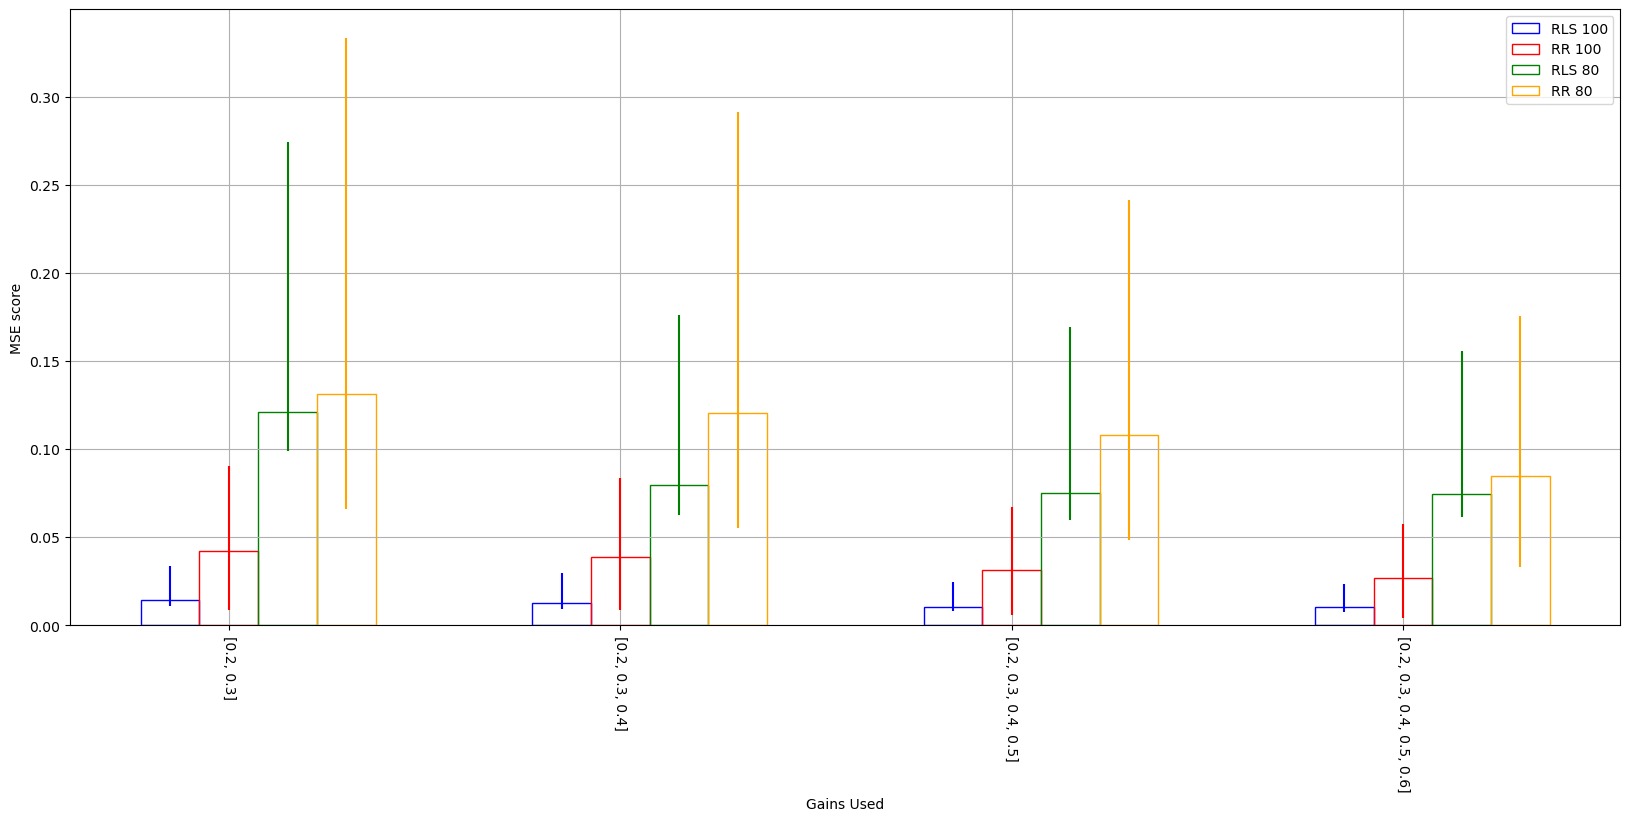

In [67]:
plt.rcParams["figure.figsize"] = (20,8)
indx = [0, 4, 8, 12]
barWidth=0.15
x = range(len(indx))
br1 = x
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 
br = [br1, br2, br3, br4]
color=['b','r', 'g', 'orange']

for i in range(len(mse)):
    y = mse[i][indx]
    yerr = np.array([per[i][indx,  0], per[i][indx,  1]])
    #plt.hlines(np.min(y), np.min(x), np.max(x)+barWidth*3, color=color[i] )
    plt.bar(br[i], y, fill=False, width = barWidth, label=labels[i], edgecolor=color[i])
    plt.errorbar(br[i], y, yerr=yerr, ls='', color=color[i])
    
    
plt.xticks([r + barWidth for r in range(len(indx))], labels=llist_to_str(gains)[indx], rotation=-90)
plt.xlabel('Gains Used')
plt.ylabel('MSE score')
plt.legend()
plt.grid(which='both')
#plt.savefig('?D Gain BarPLot')

In [10]:
def load_cov(dim):
    cov_100 = np.zeros(nr_gains)    # Average offline short MSE
    iqr_cov_100 = np.zeros((nr_gains, 2))
    cov_80 = np.zeros(nr_gains)    # Average offline short MSE
    iqr_cov_80 = np.zeros((nr_gains, 2))
    for i in range(nr_gains):
        name = f'Benchmark {dim}D BestGain Setting {i}of{nr_gains}'
        filename = f'Results\\ID {name}\\summary.pickle'
        data = load_object(filename)
        cov_100[i] = data['avg coverage']
        iqr_cov_100[i] = data['per coverage']
        cov_80[i] = data['avg coverage train']
        iqr_cov_80[i] = data['per coverage train'] 

    return cov_100, iqr_cov_100, cov_80, iqr_cov_80

# Plot Activity and Trajectory

In [16]:
setting = 8
nr_gains = 16
name = f'Benchmark 2D BestGain Setting {setting}of{nr_gains}'
filename = f'Results\\ID {name}\\summary.pickle'
data = load_object(filename)
#print(f'Reading from file : {filename}')
mse_on = data['avg online mse']
std_on = data['std online mse']
per_on = data['per online mse']
mse_onSh = data['avg online short mse']
std_onSh = data['std online short mse']
per_onSh = data['per online short mse']
mse_of = data['avg offline mse']
std_of = data['std offline mse']
per_of = data['per offline mse']
mse_ofSh = data['avg offline mse short']
std_ofSh = data['std offline mse short']
per_ofSh = data['per offline mse short']
cov_100 = data['avg coverage']
iqr_cov_100 = data['per coverage']
cov_80 = data['avg coverage train']
iqr_cov_80 = data['per coverage train']
    
gains = data['setting var']
mse = [mse_on, mse_of, mse_onSh, mse_ofSh]
std = [std_on, std_of, std_onSh, std_ofSh]
per = [per_on, per_of, per_onSh, per_ofSh]
labels = ['RLS 100', 'RR 100', 'RLS 80', 'RR 80']

filename = f'Results\\ID {name}\\data trial0.pickle'
data = load_object(filename)

time = data['sim time']
activity = np.array(data['activity'])
pos_i = np.array(data['position internal'])
pos_pon100 = np.array(data['online prediction'])
pos_pof100 = np.array(data['offline prediction'])

pos_labels = ['Internal', 'RLS 100', 'RR 100']

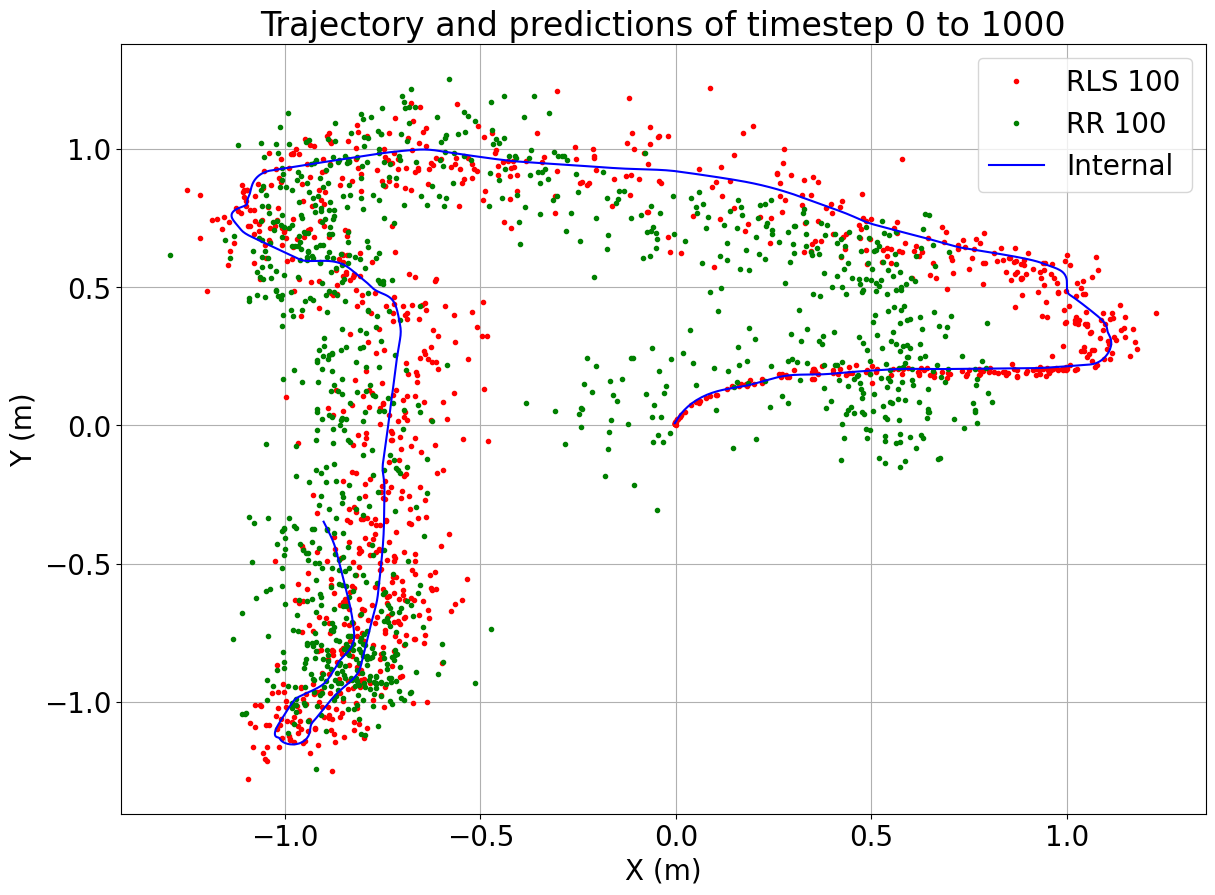

In [17]:
start = 0#-1000
stop = 1000
plt.title(f'Trajectory and predictions of timestep {start if start >= 0 else len(pos_i)-start} to {stop if stop > 0 else len(pos_i)-stop}')
plt.plot(pos_pon100[start:stop,0], pos_pon100[start:stop,1], 'r.', label = 'RLS 100')
plt.plot(pos_pof100[start:stop,0], pos_pof100[start:stop,1], 'g.', label = 'RR 100')
plt.plot(pos_i[start:stop,0], pos_i[start:stop,1], 'b-', label = 'Internal')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.grid()
plt.legend()
plt.savefig('Results\\Trajectory2Dstart.png', format = 'png')
plt.show()

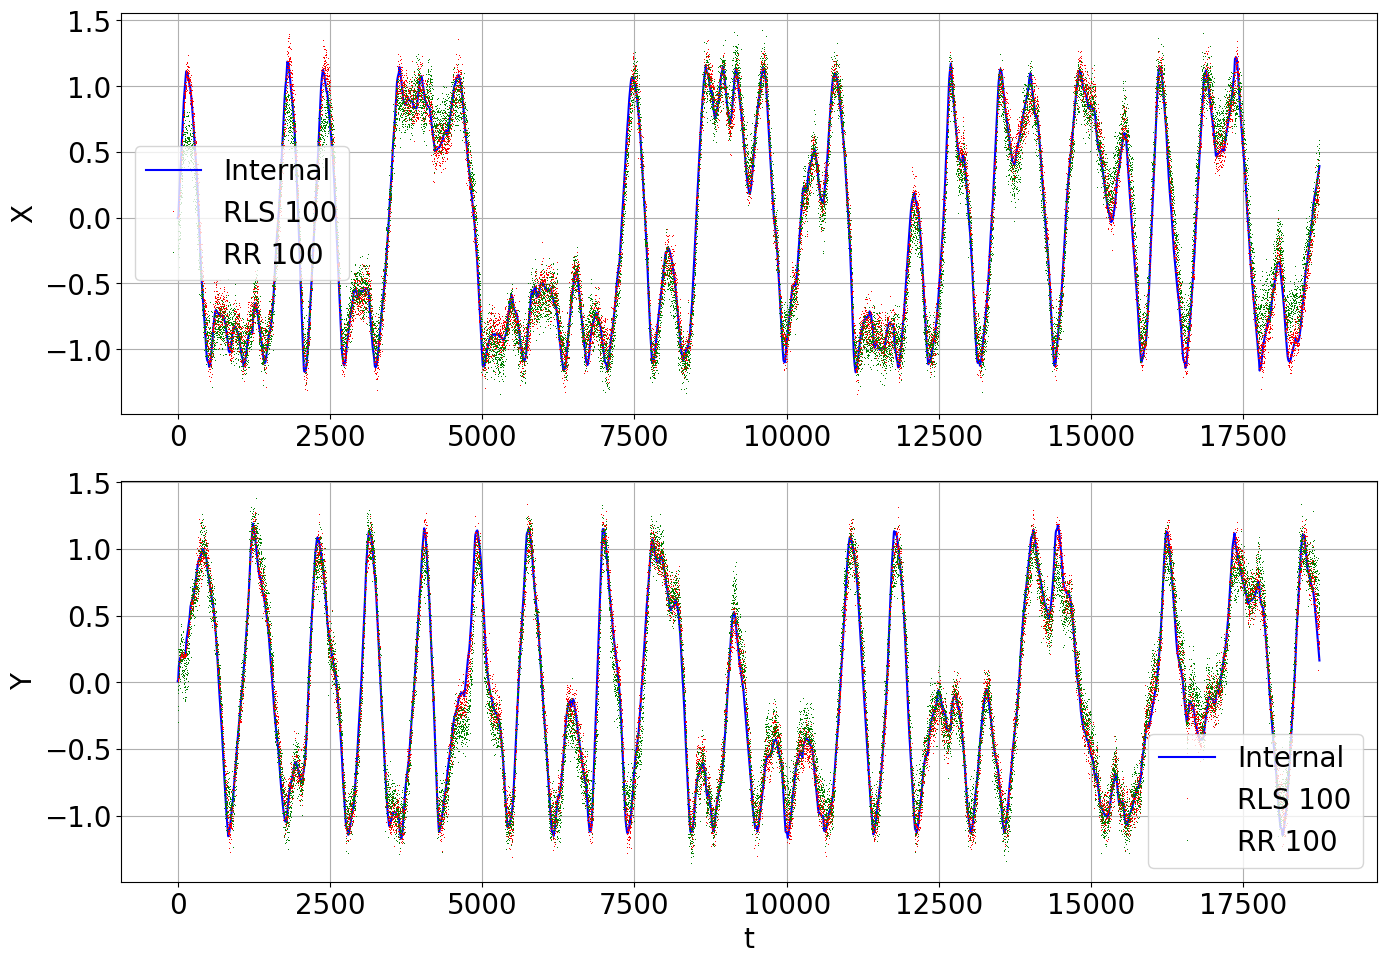

In [18]:
XYoverTime(pos_i, pos_pon100, pos_pof100, pos_labels, ['b-', 'r,', 'g,'])

In [19]:
ntime, nmod, ngain, nneuron = np.shape(activity)
neurons = nmod*ngain*nneuron

In [20]:
setting = 1
nr_gains = 2
name = f'Benchmark activity Setting {setting}of{nr_gains}'
filename = f'Results\\ID {name}\\data trial0.pickle'
data = load_object(filename)

activity = np.array(data['activity no noise'])
pos_i = np.array(data['position internal'])
prj_op = np.array(data['module operators'])
projection = np.array(data['modular projections'])
gains = np.array(data['gains'])

0
Projection in ['X' 'Y']


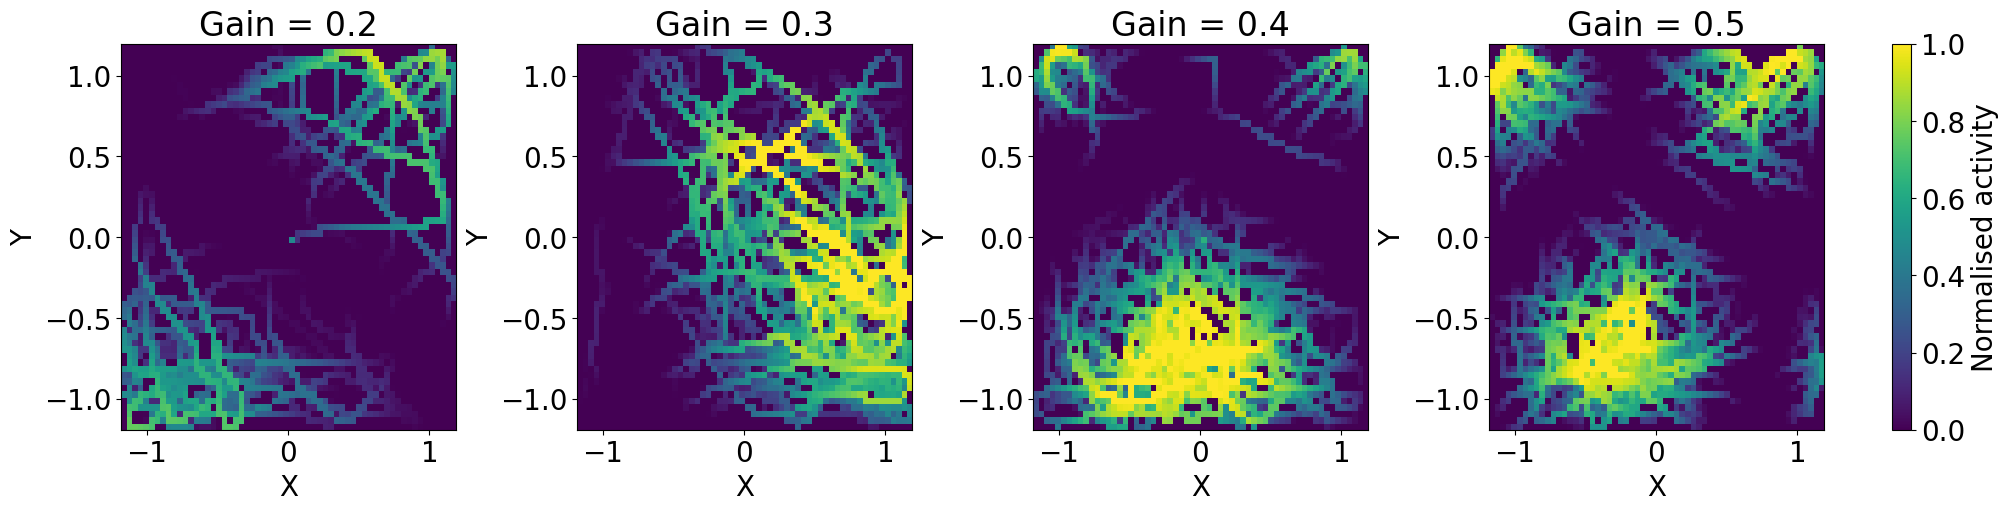

1
Projection in ['X' 'Y']


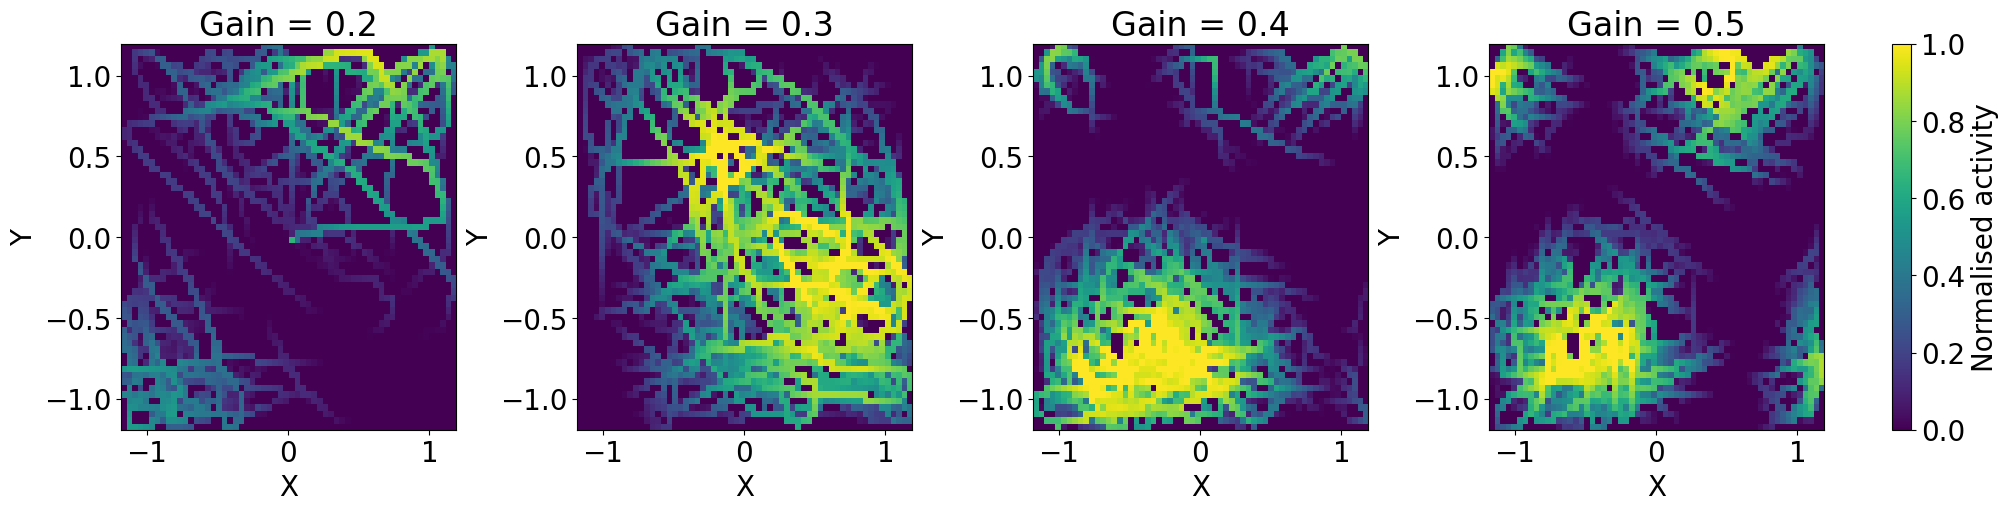

2
Projection in ['X' 'Y']


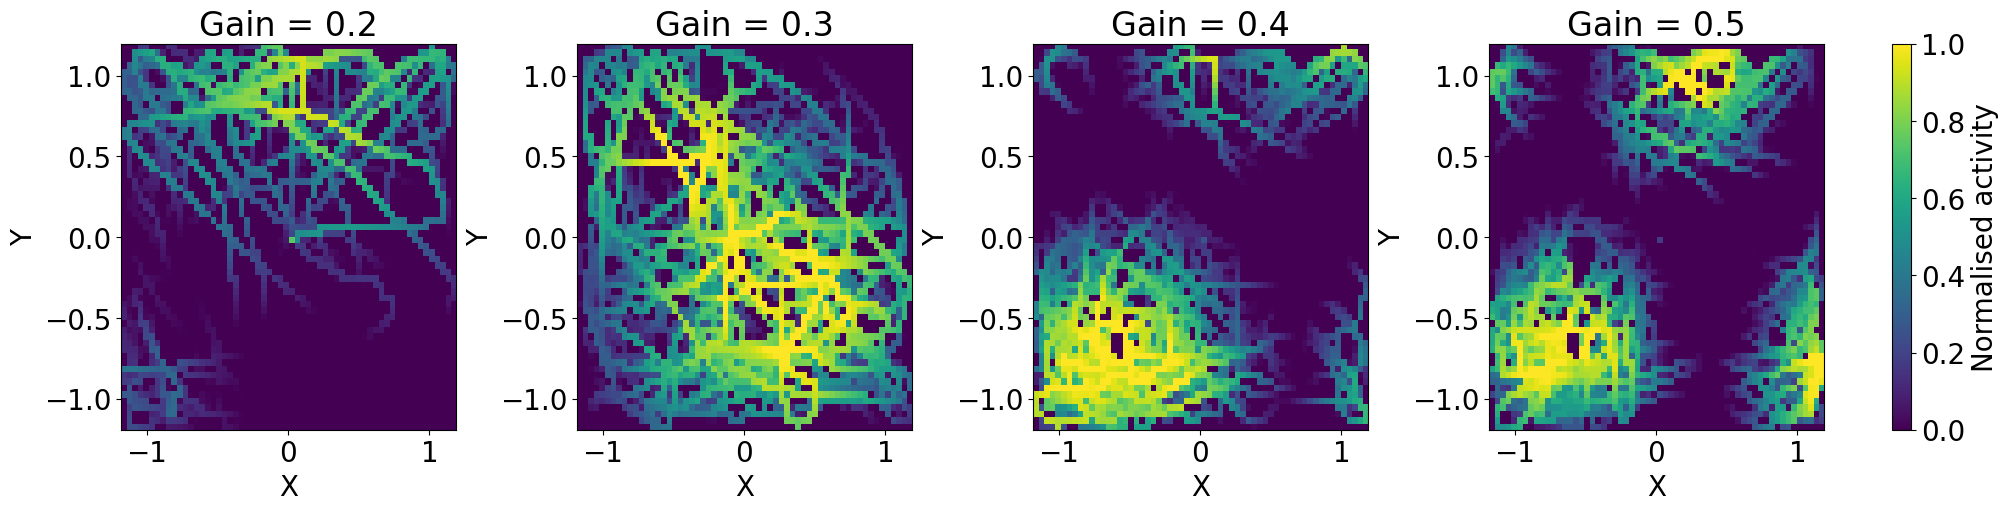

3
Projection in ['X' 'Y']


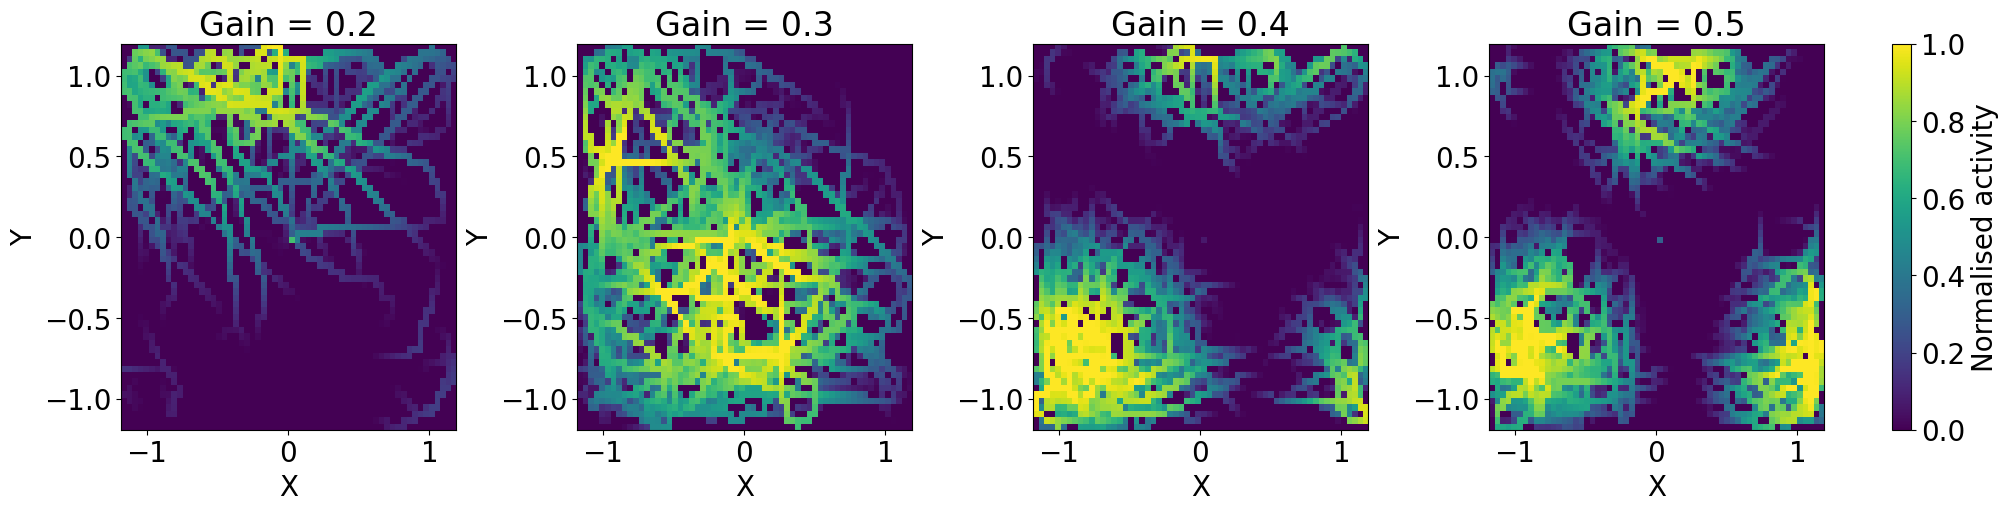

4
Projection in ['X' 'Y']


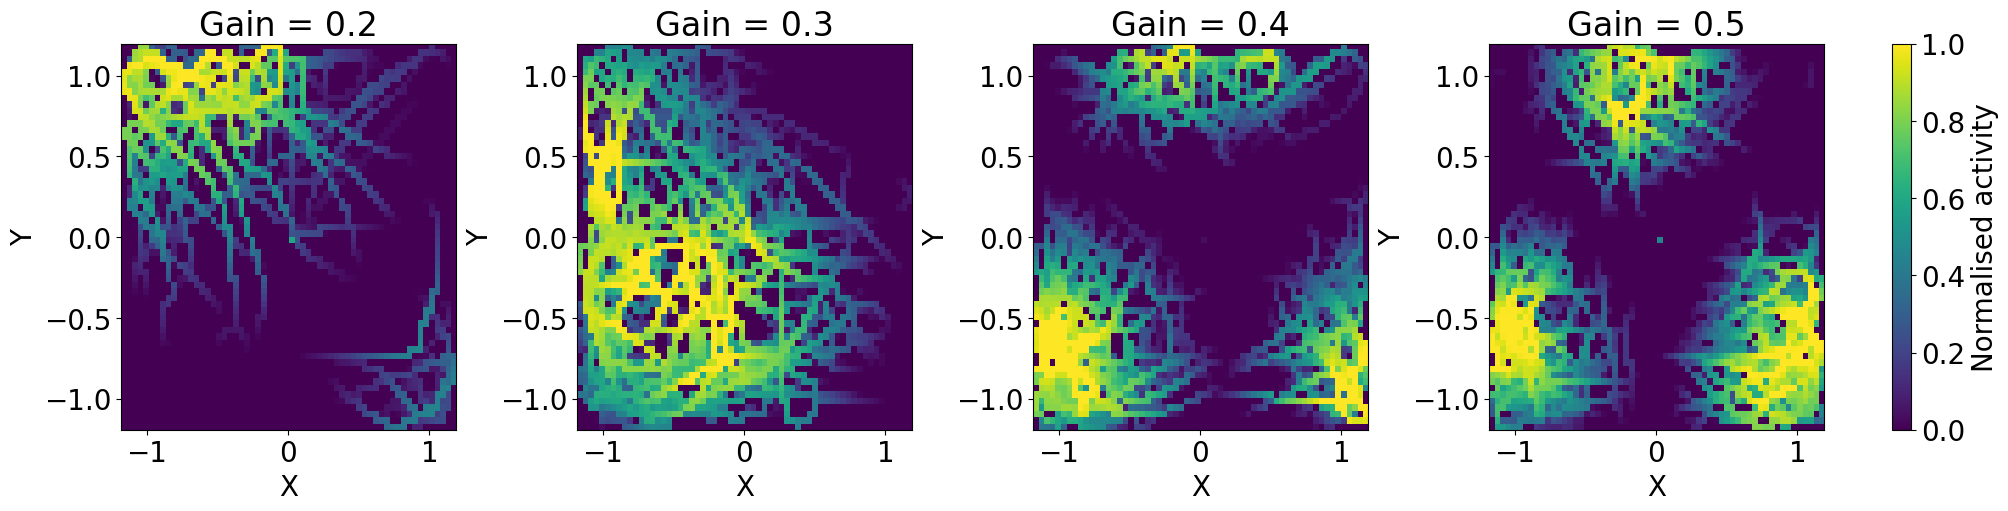

5
Projection in ['X' 'Y']


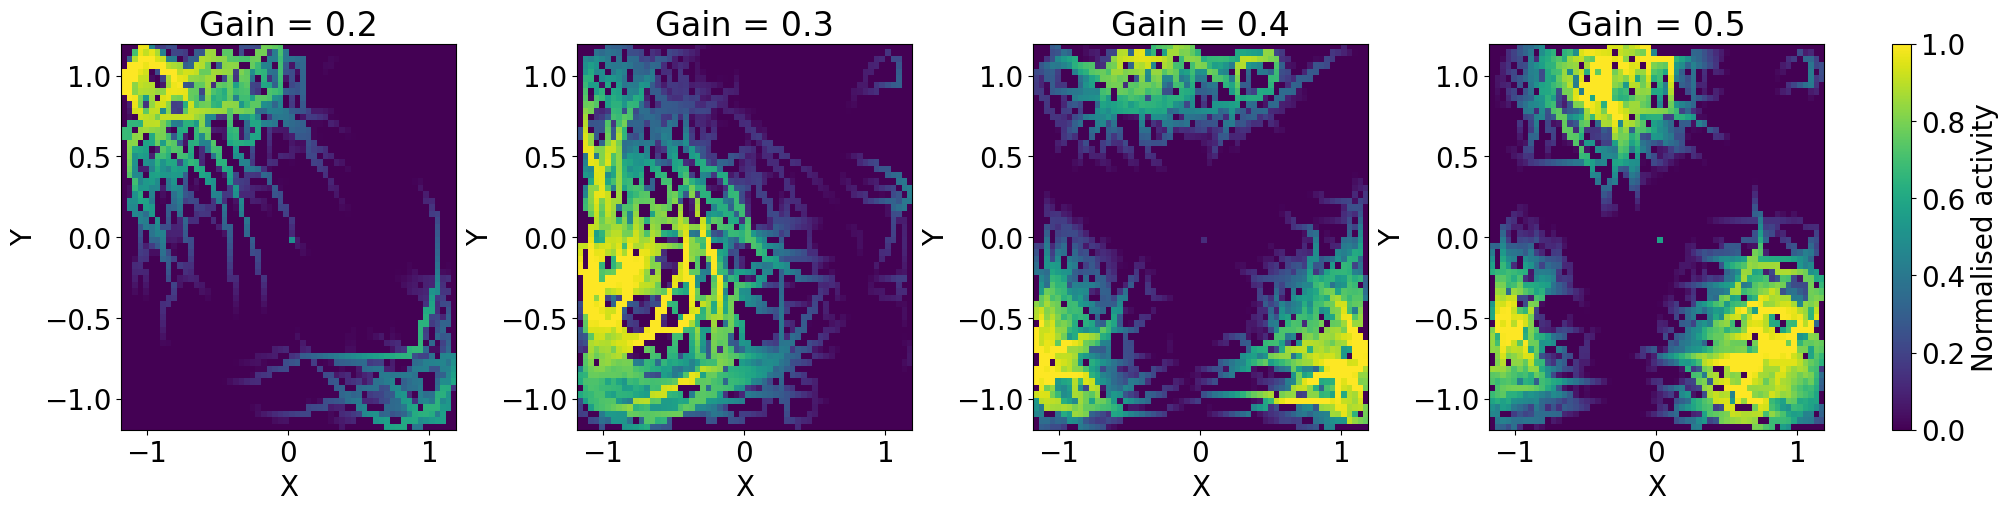

6
Projection in ['X' 'Y']


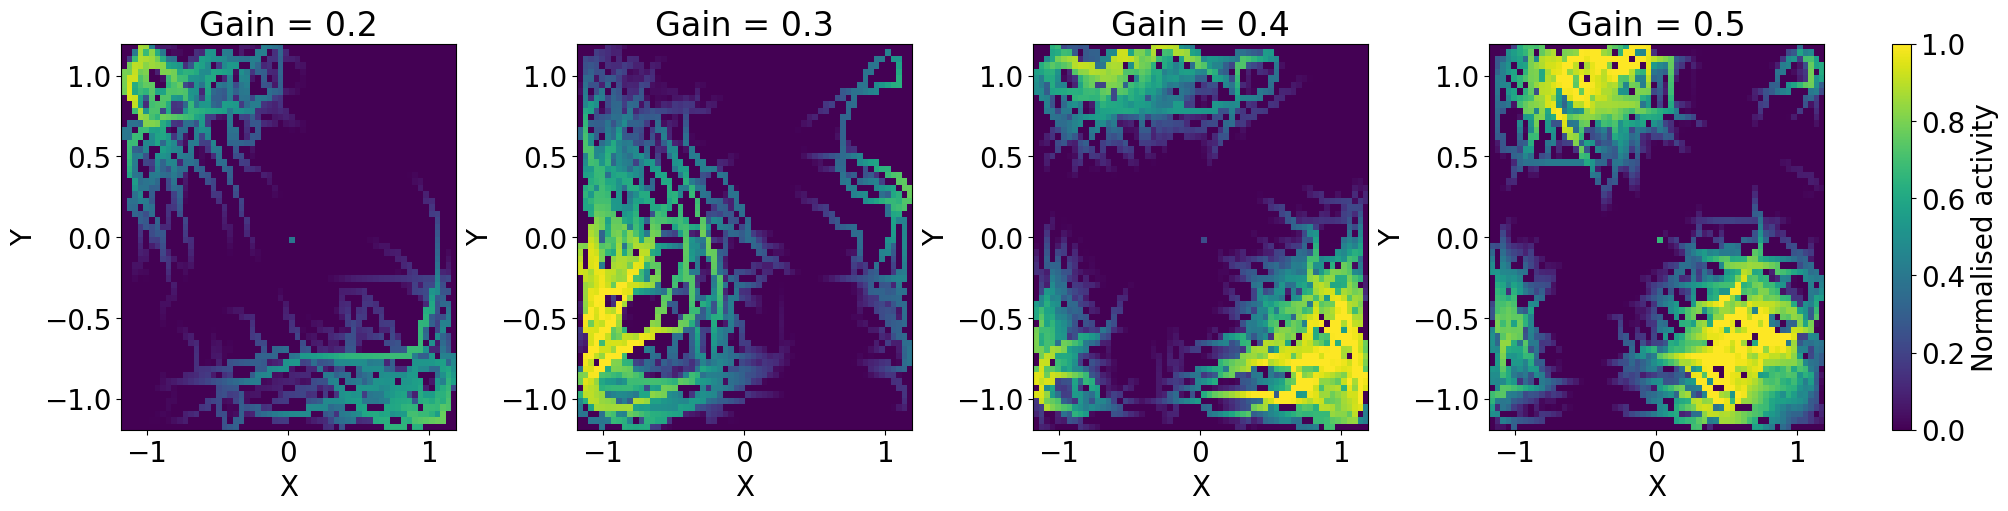

7
Projection in ['X' 'Y']


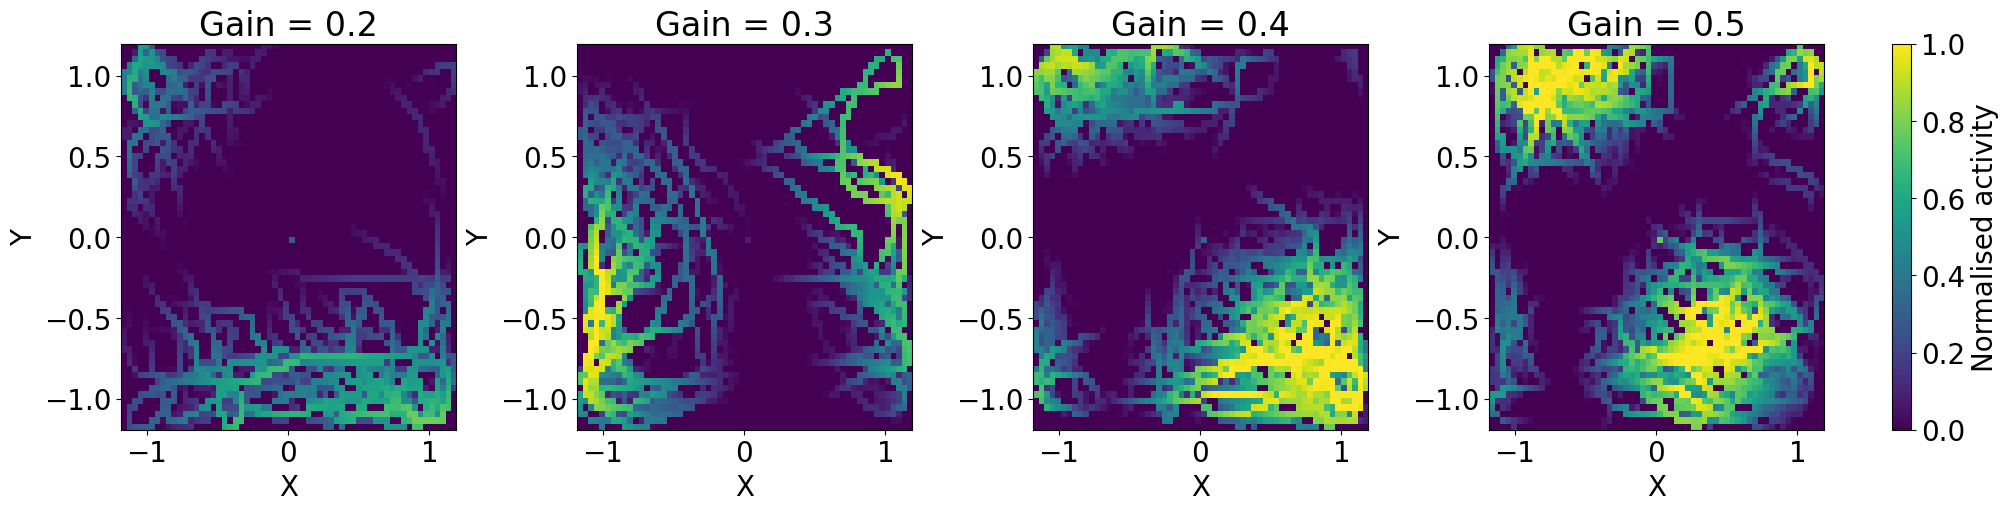

8
Projection in ['X' 'Y']


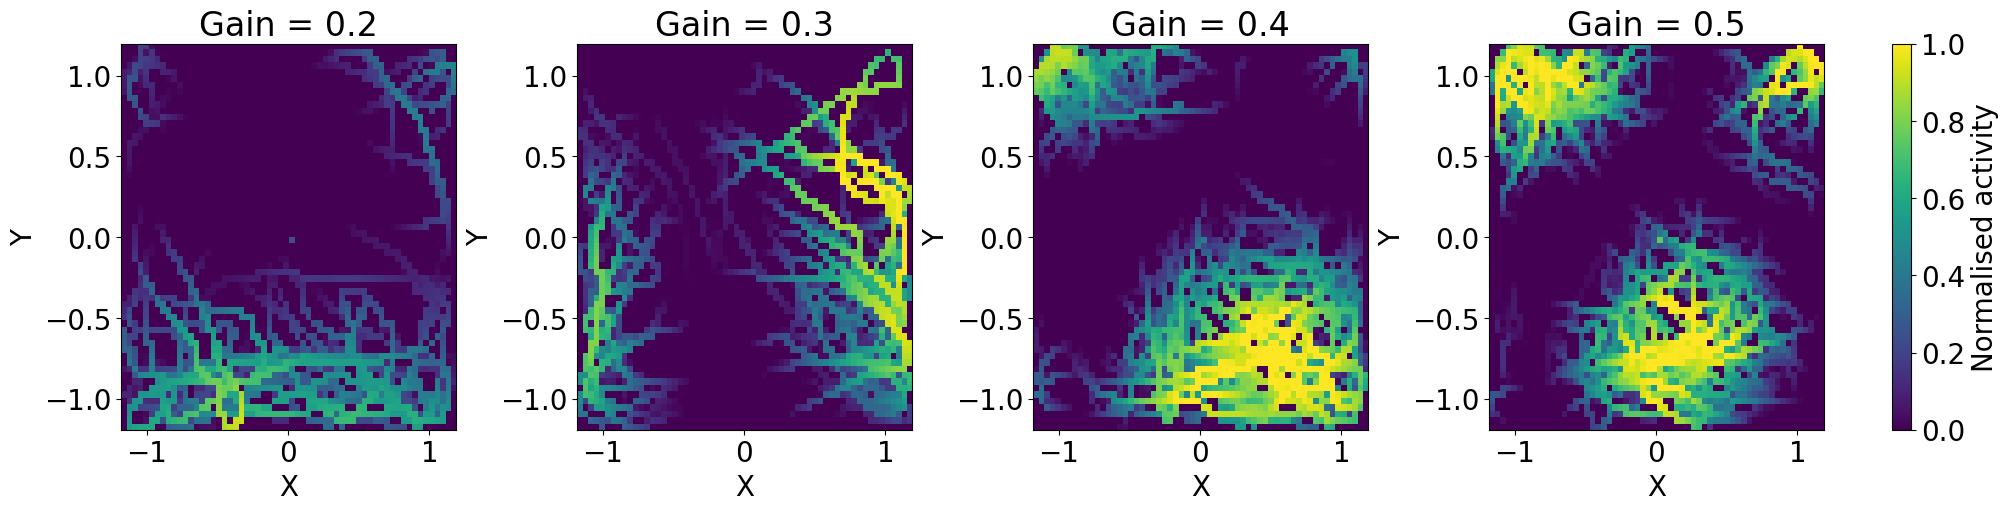

9
Projection in ['X' 'Y']


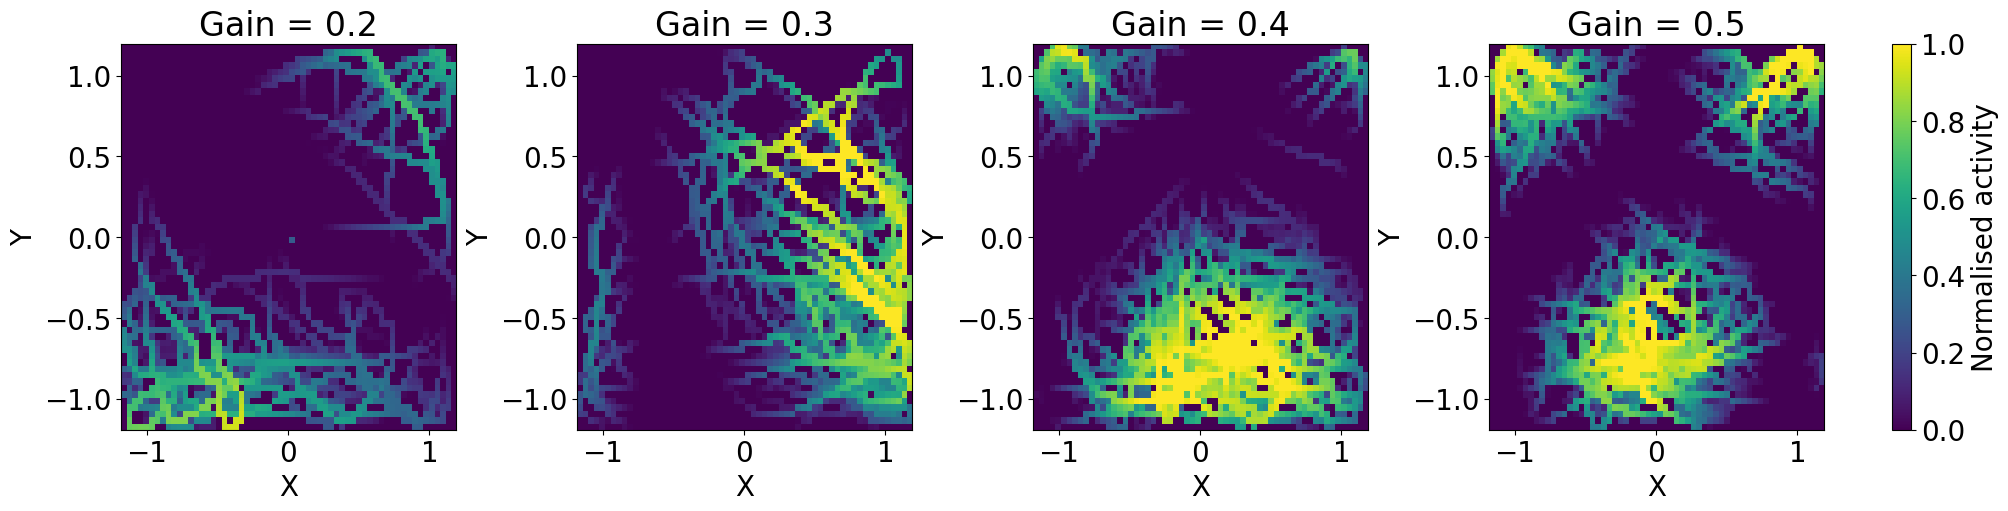

10
Projection in ['X' 'Y']


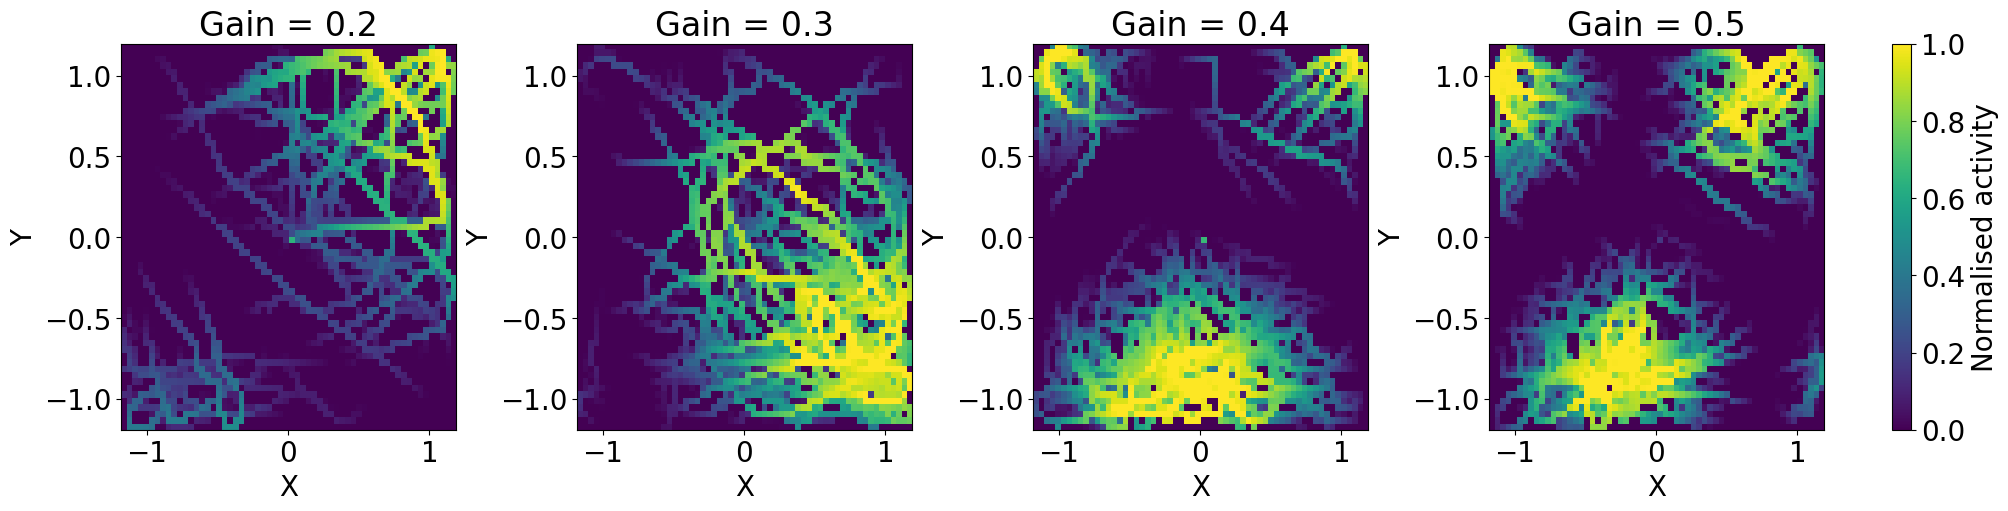

11
Projection in ['X' 'Y']


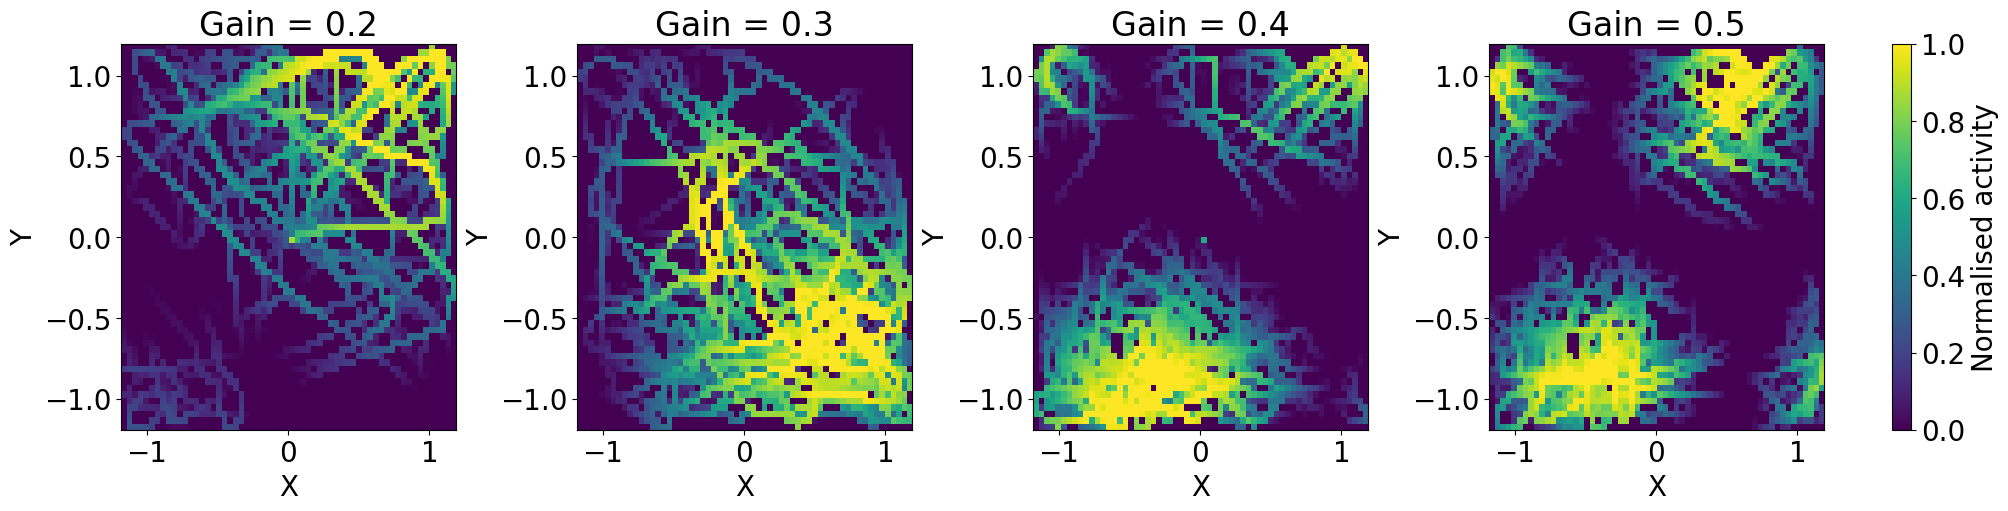

12
Projection in ['X' 'Y']


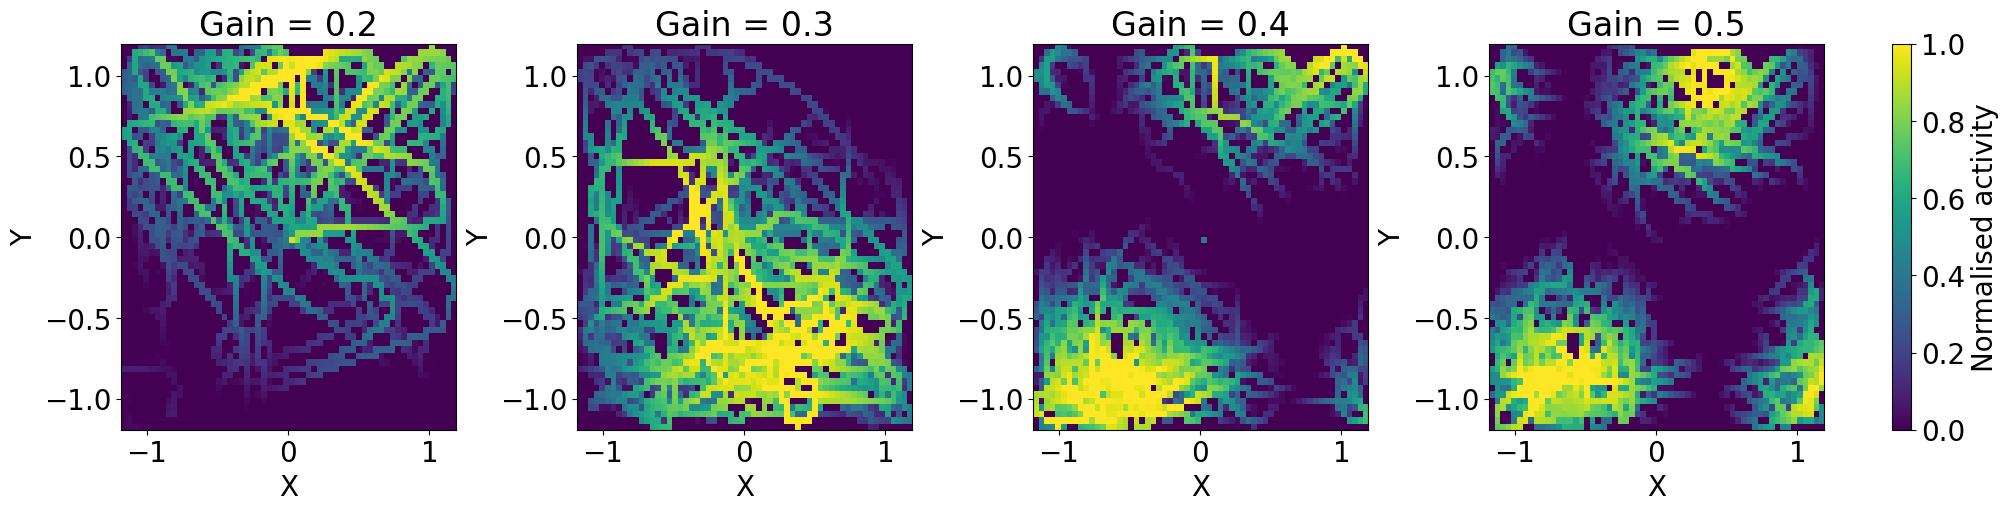

13
Projection in ['X' 'Y']


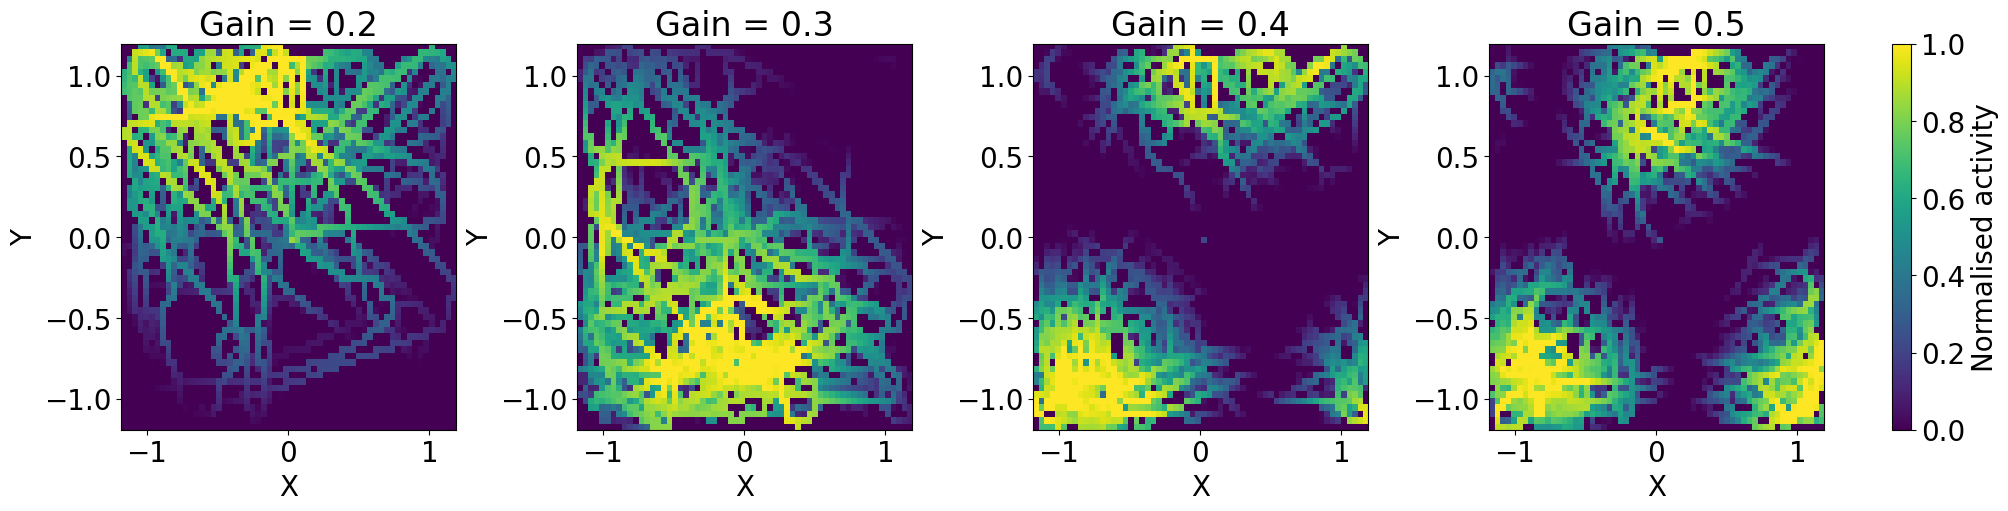

14
Projection in ['X' 'Y']


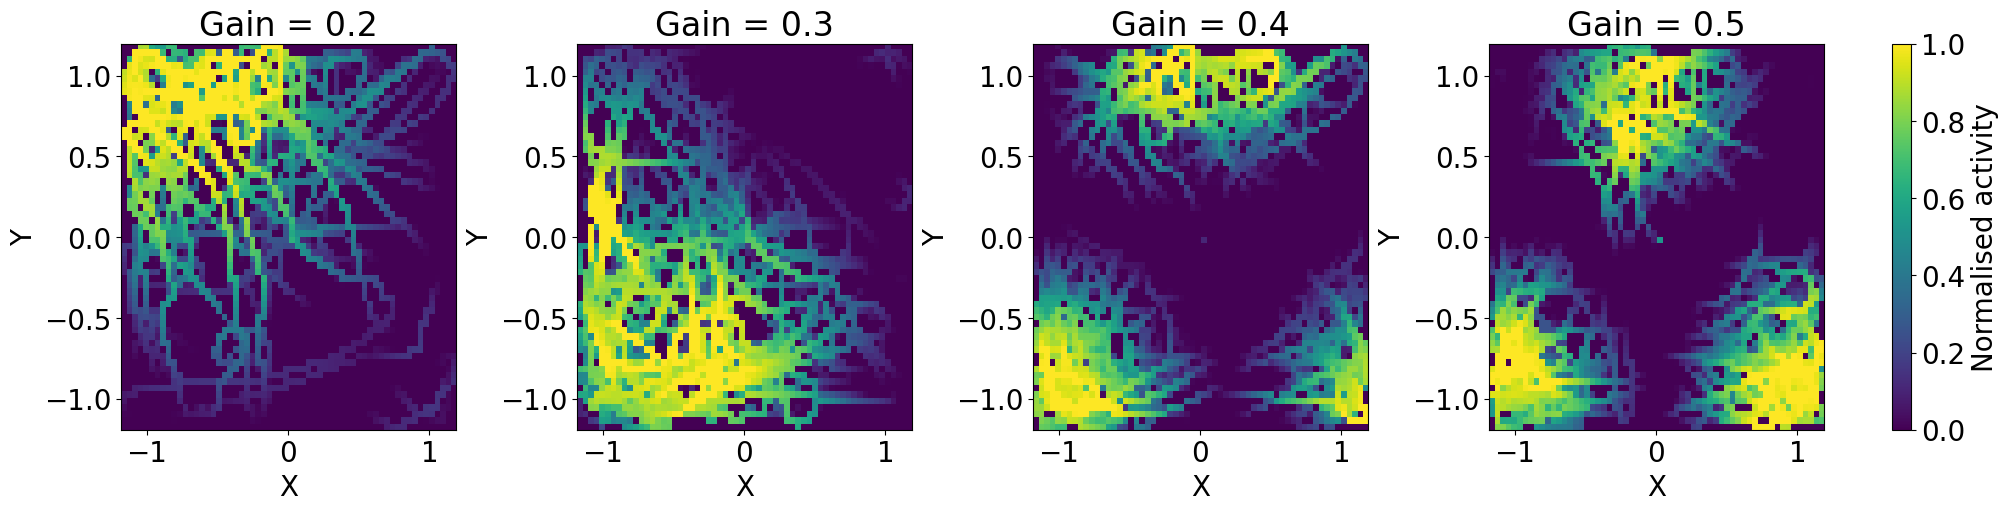

15
Projection in ['X' 'Y']


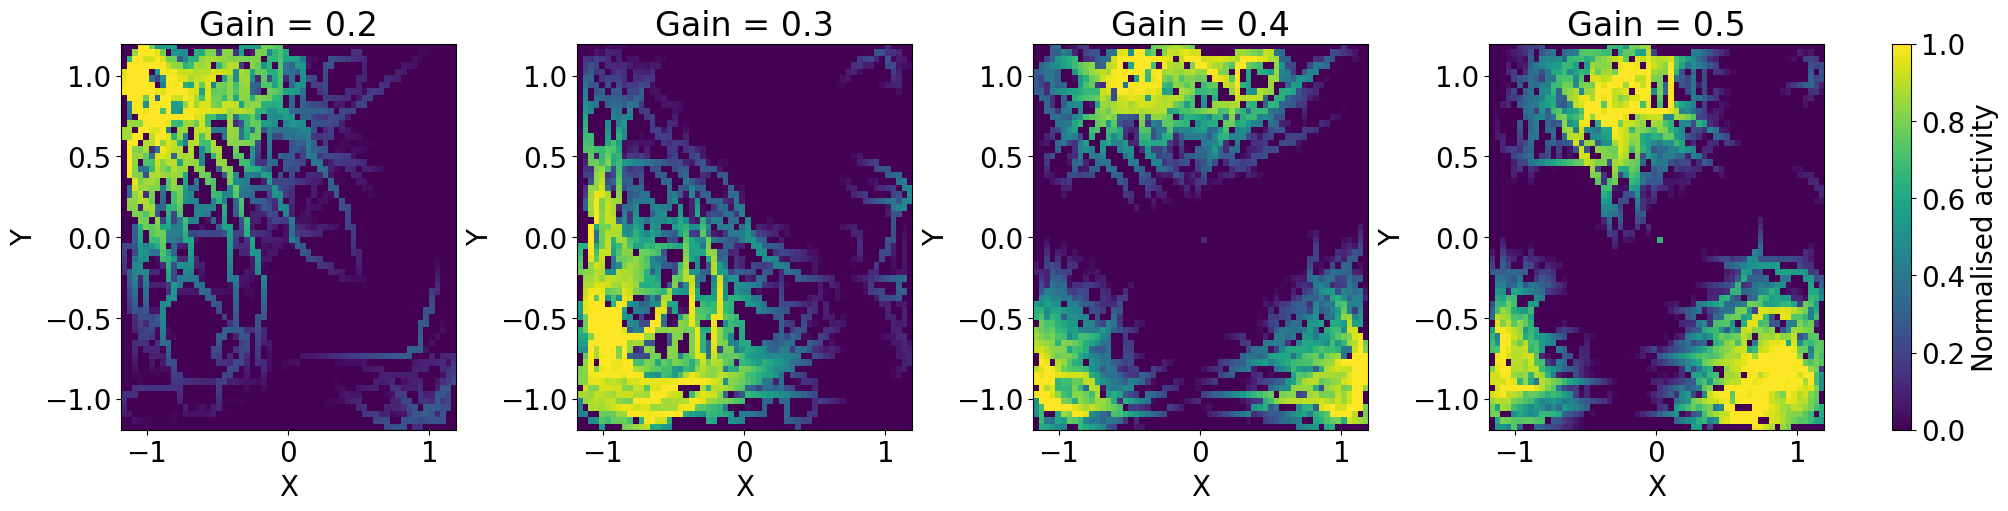

16
Projection in ['X' 'Y']


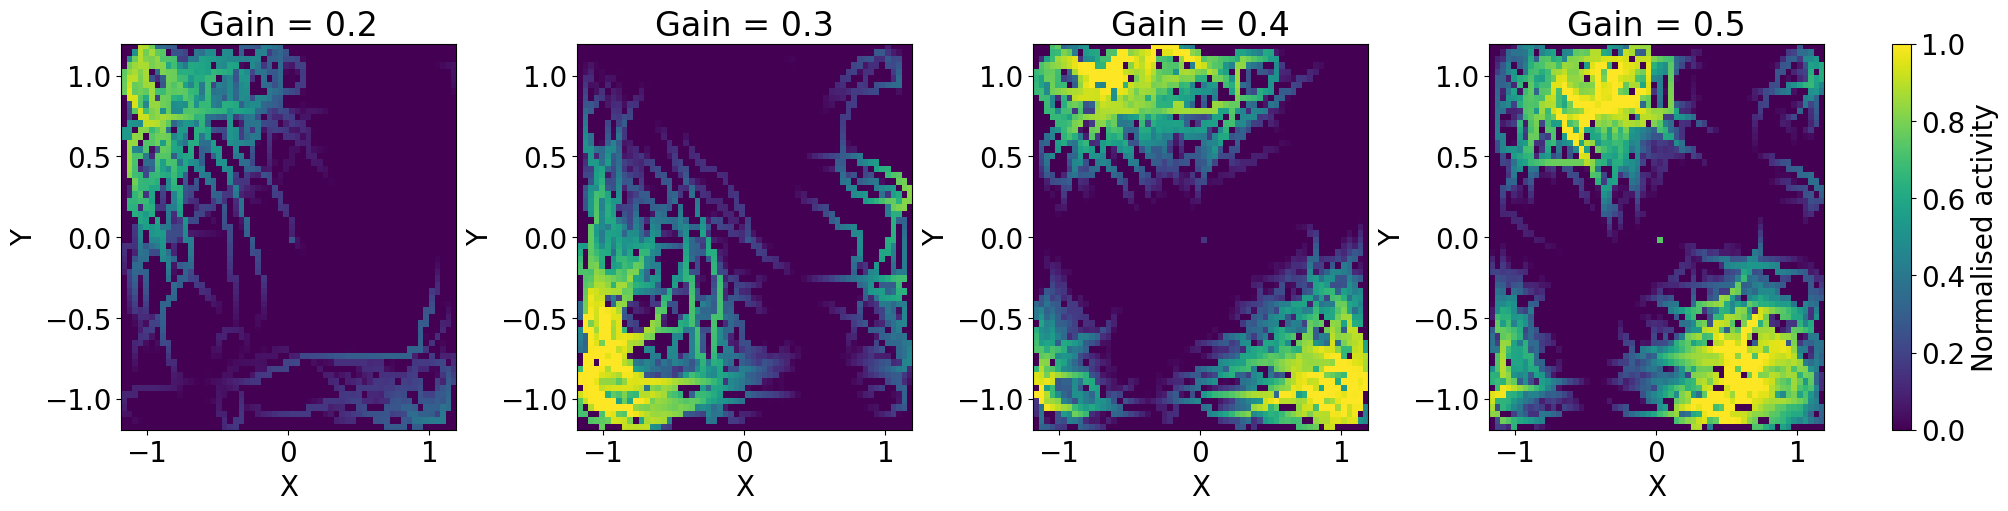

17
Projection in ['X' 'Y']


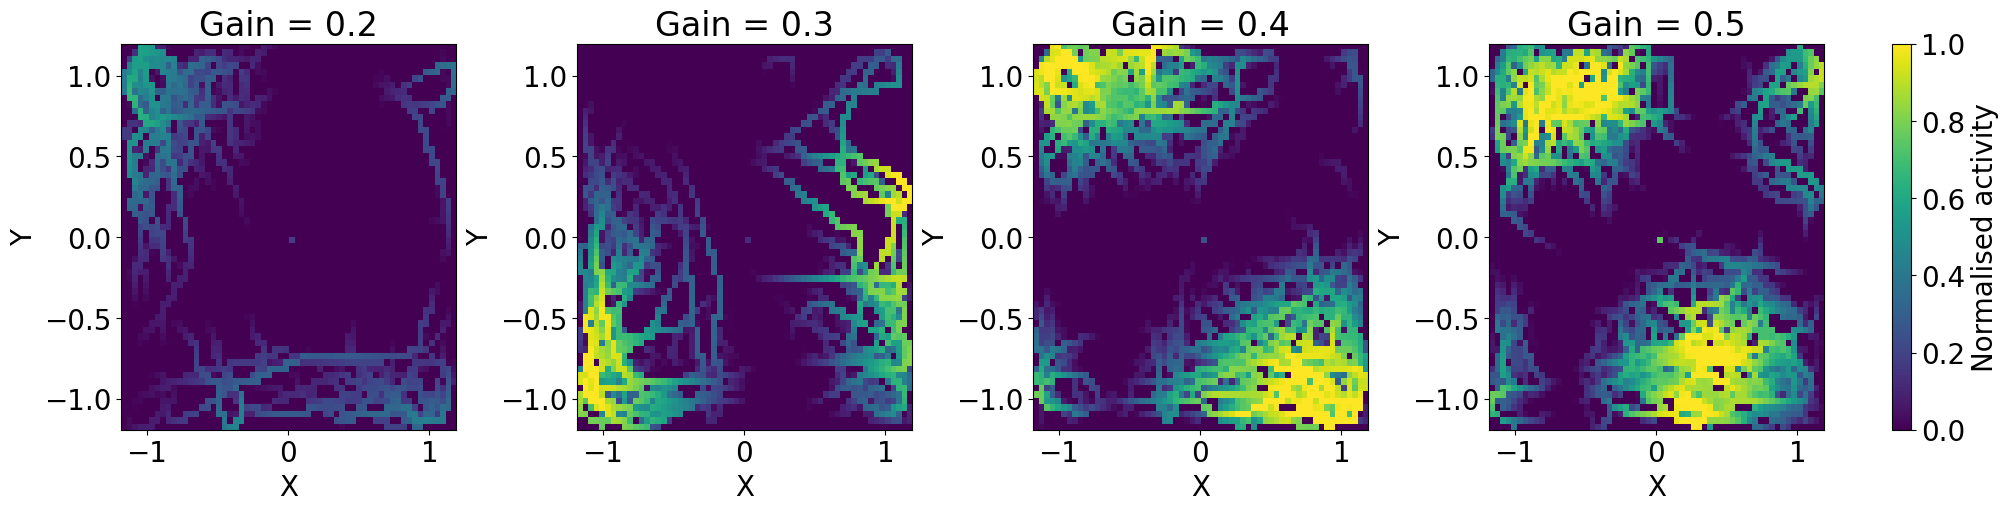

18
Projection in ['X' 'Y']


In [ ]:
for i in range(neurons):
    print(i)
    plot_modular_activity(prj_op, pos_i, activity, gains, projection, neuron=i, save=True)

In [22]:
def plot_modular_activity(prj_op, pos, ac, gains, projection, neuron=0, save=False):
    pos2d = np.einsum('mnx, tx->mtn', prj_op, pos)
    abc = np.array(['X', 'Y', 'Z'] if len(projection)==3 else ['X', 'Y']) 
    for i, p in enumerate(pos2d):
        print(f'Projection in {abc[projection[i]]}')
        heatmap, x_edge, y_edge = get_heatmap(p, ac[:,i], num_bins=60, neuron=neuron)
        fig, ax, cbar = plot_heatmaps(heatmap, x_edge, y_edge, gains = gains, dimensions=abc[projection[i]])
        if save:
            plt.savefig(f'ActivityPlane{abc[projection[i]]}neuron{neuron}2D.png', format='png')
        plt.show()
        
def get_heatmap(positions, activity, num_bins=50, neuron=0):
    """
    Generate a 3D heatmap of neural activity over XY space for different gain levels.

    Parameters
    ----------
    positions : array-like, shape = (ntime, 2)
        XY coordinates at each timepoint.
    activity : array-like, shape = (ntime, ngain, nneuron)
        Neural activity: time x gain levels x neurons.
    num_bins : int, optional (default=50)
        Number of bins along each spatial dimension.
    neuron : int, optional (default=42)
        Index of the neuron to plot.

    Returns
    -------
    heatmap : ndarray, shape = (ngain, num_bins, num_bins)
        Average activity of the specified neuron in each spatial bin for each gain.
        Bins with no samples are set to 0.
    x_edges : ndarray, shape = (num_bins + 1,)
        Bin edges along the X dimension.
    y_edges : ndarray, shape = (num_bins + 1,)
        Bin edges along the Y dimension.
    """
    positions = np.asarray(positions)
    activity = np.asarray(activity)

    # Validate dimensions
    ntime, dims = positions.shape
    t2, ngain, nneuron = activity.shape
    if t2 != ntime:
        raise ValueError(f"Time dimension mismatch: positions has {ntime}, activity has {t2}.")
    if neuron < 0 or neuron >= nneuron:
        raise ValueError(f"Neuron index out of bounds: should be in [0, {nneuron-1}].")

    # Define bin edges
    x_edges = np.linspace(positions[:, 0].min(), positions[:, 0].max(), num_bins + 1)
    y_edges = np.linspace(positions[:, 1].min(), positions[:, 1].max(), num_bins + 1)

    # Initialize accumulators
    sum_map = np.zeros((ngain, num_bins, num_bins), dtype=float)
    count_map = np.zeros((ngain, num_bins, num_bins), dtype=int)

    # Bin each sample
    for (x, y), act in zip(positions, activity):
        x_idx = np.clip(np.digitize(x, x_edges) - 1, 0, num_bins - 1)
        y_idx = np.clip(np.digitize(y, y_edges) - 1, 0, num_bins - 1)
        for g in range(ngain):
            sum_map[g, x_idx, y_idx] = max(act[g, neuron], sum_map[g, x_idx, y_idx])
            count_map[g, x_idx, y_idx] += 1

    # Compute average, set empty bins to 0
    heatmap = np.zeros_like(sum_map)
    nonzero = count_map > 0
    heatmap[nonzero] = sum_map[nonzero] #/ count_map[nonzero]
    # bins with no data remain 0

    return heatmap, x_edges, y_edges

def plot_heatmaps(heatmap, x_edges, y_edges, gains=None, cmap='viridis', dimensions=['X', 'Y']):
    """
    Plot one heatmap per gain level with a shared colorbar.

    Parameters
    ----------
    heatmap : ndarray, shape = (ngain, nbins, nbins)
        Heatmap data for each gain.
    x_edges : array-like, shape = (nbins + 1,)
        Bin edges along the X dimension.
    y_edges : array-like, shape = (nbins + 1,)
        Bin edges along the Y dimension.
    gains : list or array-like, optional
        Gain values corresponding to each heatmap slice. If None, gains are numbered 0..ngain-1.
    cmap : str, optional
        Matplotlib colormap name.

    Returns
    -------
    fig, axes, cbar : tuple
        Figure, axes array and the shared colorbar.
    """
    ngain, nbins, _ = heatmap.shape
    if gains is None:
        gains = np.arange(ngain)
    elif len(gains) != ngain:
        raise ValueError(f"Length of gains ({len(gains)}) must match heatmap dimension ({ngain}).")

    # Compute bin centers for plotting
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2

    fig, axes = plt.subplots(1, ngain, figsize=(5 * ngain, 5), constrained_layout=True)
    if ngain == 1:
        axes = [axes]

    vmin = np.min(heatmap)
    vmax = np.max(heatmap)

    for idx, ax in enumerate(axes):
        im = ax.imshow(
            heatmap[idx].T,
            origin='lower',
            extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]),
            aspect='auto',
            vmin=vmin,
            vmax=vmax,
            cmap=cmap
        )
        ax.set_title(f'Gain = {gains[idx]}')
        ax.set_xlabel(dimensions[0])
        ax.set_ylabel(dimensions[1])

    # Colorbar
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Normalised activity')

    return fig, axes, cbar

# Performance Coverage

In [7]:
settings = 12

# Initialize arrays to store results
mse_on = np.zeros(settings)      # Average online MSE
std_on = np.zeros(settings)      # Standard deviation online MSE
per_on = np.zeros((settings, 2))

mse_onSh = np.zeros(settings)    # Average online short MSE
std_onSh = np.zeros(settings)    # Standard deviation online short MSE
per_onSh = np.zeros((settings, 2))

mse_of = np.zeros(settings)      # Average offline MSE
std_of = np.zeros(settings)      # Standard deviation offline MSE
per_of = np.zeros((settings, 2))

mse_ofSh = np.zeros(settings)    # Average offline short MSE
std_ofSh = np.zeros(settings)    # Standard deviation offline short MSE
per_ofSh = np.zeros((settings, 2))

cov_100 = np.zeros(settings)    # Average offline short MSE
iqr_cov_100 = np.zeros((settings, 2))
cov_80 = np.zeros(settings)    # Average offline short MSE
iqr_cov_80 = np.zeros((settings, 2))

time = np.zeros(settings)    # Average offline short MSE = np.zeros(settings)    # Standard deviation offline short MSE
time_iqr = np.zeros((settings, 2))

for i in range(settings):
    name = f'Benchmark Performance Setting {i}of{settings}'
    filename = f'Results\\ID {name}\\summary.pickle'
    data = load_object(filename)
    #print(f'Reading from file : {filename}')
        
    mse_on[i] = data['avg online mse']
    std_on[i] = data['std online mse']
    per_on[i] = data['per online mse']
    
    mse_onSh[i] = data['avg online short mse']
    std_onSh[i] = data['std online short mse']
    per_onSh[i] = data['per online short mse']
    
    mse_of[i] = data['avg offline mse']
    std_of[i] = data['std offline mse']
    per_of[i] = data['per offline mse']
    
    mse_ofSh[i] = data['avg offline mse short']
    std_ofSh[i] = data['std offline mse short']
    per_ofSh[i] = data['per offline mse short']
    
    cov_100[i] = data['avg coverage']
    iqr_cov_100[i] = data['per coverage']
    cov_80[i] = data['avg coverage train']
    iqr_cov_80[i] = data['per coverage train']

    time[i] = data['avg time total']
    time_iqr[i] = data['per time total']

    #filename = f'Results\\ID {name}\\data trial0.pickle'
    #data = load_object(filename)
    
times = data['setting var']
mse = [mse_on, mse_of, mse_onSh, mse_ofSh]
std = [std_on, std_of, std_onSh, std_ofSh]
iqr = [per_on, per_of, per_onSh, per_ofSh]
setting = ['[0.2, 0.3, 0.4, 0.5], 2D', '[0.2, 0.3, 0.4, 0.5, 0.6], 2D', '[0.2, 0.3, 0.4, 0.5], 3D', '[0.2, 0.3, 0.4, 0.5, 0.6], 3D']
decoder_names = ['RLS 100', 'RR 100', 'RLS 80', 'RR 80']

In [13]:
a = np.array(llist_to_str(times), dtype=object)
a[[0, 1, 2]] = a[[0,1,2]] + 'min, Gains1, 2D'
a[[3, 4, 5]] = a[[3,4,5]] + 'min, Gains2, 2D'
a[[6, 7, 8]] = a[[6,7,8]] + 'min, Gains1, 3D'
a[[9, 10, 11]] = a[[9,10,11]] + 'min, Gains2, 3D'
print(a)

['5.0min, Gains1, 2D' '10.0min, Gains1, 2D' '20.0min, Gains1, 2D'
 '5.0min, Gains2, 2D' '10.0min, Gains2, 2D' '20.0min, Gains2, 2D'
 '5.0min, Gains1, 3D' '10.0min, Gains1, 3D' '20.0min, Gains1, 3D'
 '5.0min, Gains2, 3D' '10.0min, Gains2, 3D' '20.0min, Gains2, 3D']


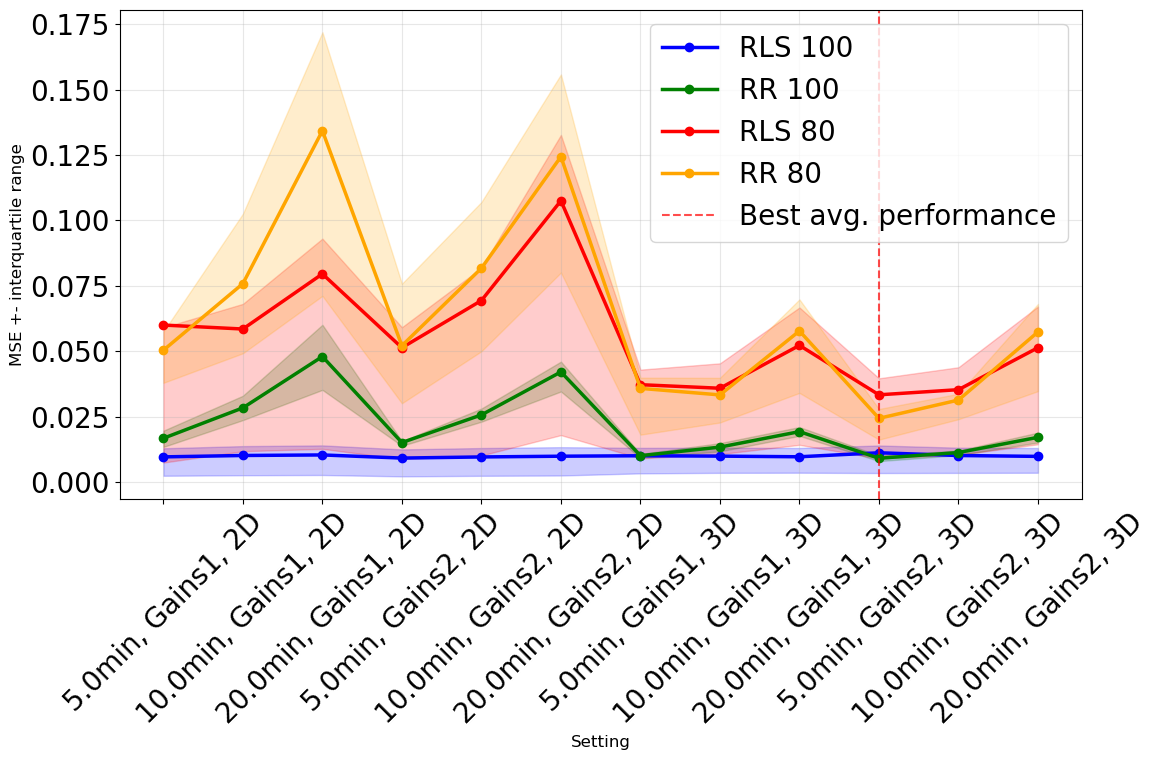

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['b', 'g', 'r', 'orange']

for i in range(4):
    # Plot main line
    ax.plot(a, mse[i], color=colors[i], linewidth=2.5, 
            label=decoder_names[i], marker='o', markersize=6)
    
    # Add confidence band (mean ± std)
    ax.fill_between(a, 
                   iqr[i][:,0], 
                   iqr[i][:,1], 
                   color=colors[i], alpha=0.2)

ax.set_xlabel('Setting', fontsize=12)
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylabel('MSE +- interquartile range', fontsize=12)
#ax.set_title('Neural Decoder Performance: MSE vs Gain Settings', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Highlight best performing regions
min_mse_idx = np.argmin(np.sum(mse, axis=0))
ax.axvline(x=a[min_mse_idx], color='red', linestyle='--', alpha=0.7, 
           label=f'Best avg. performance')
ax.legend()

plt.tight_layout()
plt.show()

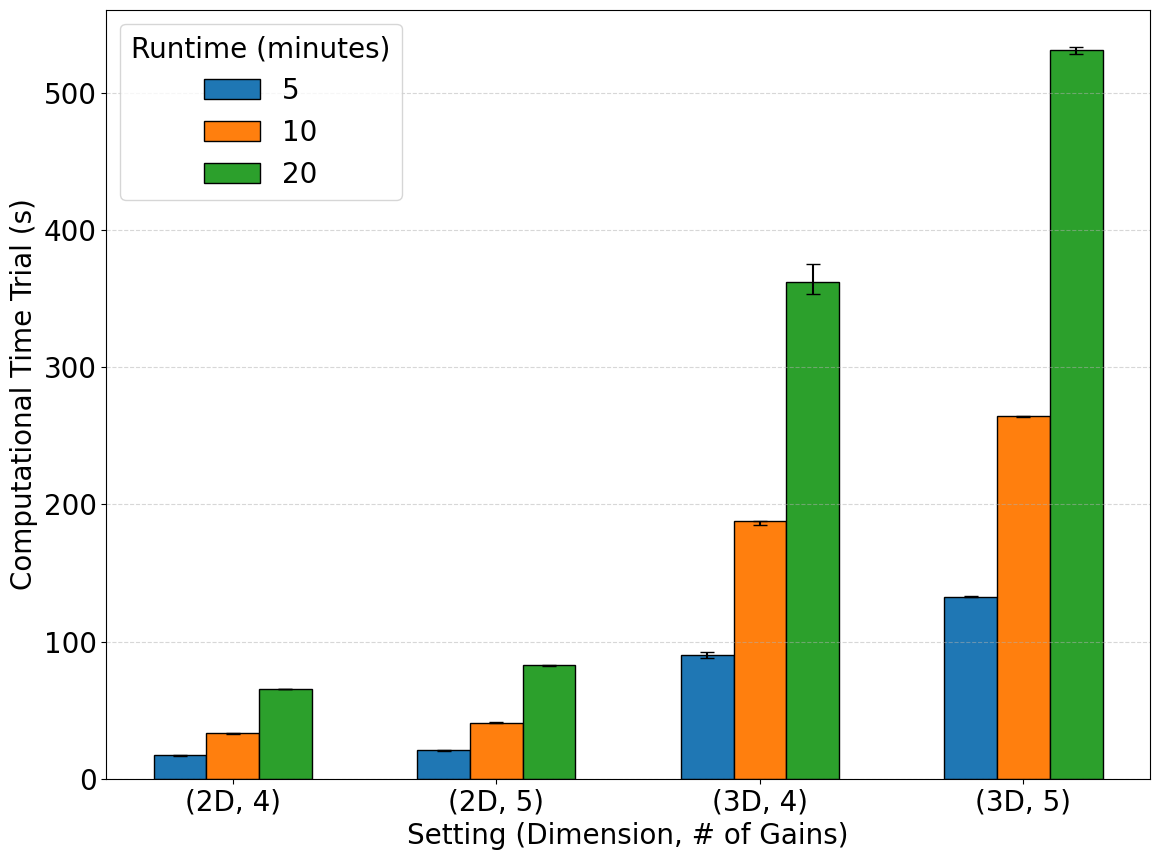

In [15]:
x       = [5, 10, 20]
labels  = ['(2D, 4)', '(2D, 5)', '(3D, 4)', '(3D, 5)']
ttime   = time.reshape((3, -1), order='F')      # shape: (3, 4)
iqr     = time_iqr.reshape((3, -1, 2), order = 'F')  # shape: (3, 4, 2)

num_datasets = len(x)
num_labels   = len(labels)
bar_width    = 0.2
x_pos        = np.arange(num_labels)

#plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(12, 9))

for i in range(num_datasets):
    # compute positive error magnitudes
    lower_err = np.abs(ttime[i] - iqr[i, :, 0])   # |center − 25th|
    upper_err = np.abs(iqr[i, :, 1] - ttime[i])   # |75th − center|
    yerr      = np.vstack((lower_err, upper_err))

    offset = (i - num_datasets/2) * bar_width + bar_width/2
    ax.bar(
        x_pos + offset,
        ttime[i],
        width=bar_width,
        label=f'{x[i]}',
        edgecolor='black',
        fill=True,
        yerr=yerr,
        capsize=5,
    )

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_xlabel('Setting (Dimension, # of Gains)')
ax.set_ylabel('Computational Time Trial (s)')
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
ax.legend(title='Runtime (minutes)')
plt.tight_layout()
plt.savefig('CompTime.png', format='png')
plt.show()

In [107]:
ttime

array([[ 17.13754753,  20.66477706,  90.00480392, 132.8113511 ],
       [ 32.96293227,  40.92285898, 187.60376956, 264.03732552],
       [ 65.64064278,  83.22224941, 362.14355864, 530.84842529]])

In [104]:
cov

[array([52.78703153, 76.61808447, 93.51873885]),
 array([47.50148721, 71.16597264, 89.35157644]),
 array([53.25401547, 76.79654967, 93.76264128]),
 array([49.85425342, 70.39559786, 89.98215348]),
 array([ 3.70402345,  6.93467884, 12.36720303]),
 array([ 3.25640951,  5.91416259, 10.51740398]),
 array([ 3.66346977,  6.90370134, 12.31576733]),
 array([ 3.22238505,  5.88245963, 10.46582319])]

In [122]:
cov_iqr

[array([[49.9405116 , 55.56216538],
        [75.594884  , 77.34979179],
        [92.93575253, 94.36347412]]),
 array([[45.31528852, 50.0446163 ],
        [70.34503272, 71.63890541],
        [88.71207615, 89.94646044]]),
 array([[ 3.67232048,  3.73434802],
        [ 6.88650774,  6.98879877],
        [12.31953976, 12.45919241]]),
 array([[ 3.23522584,  3.28201854],
        [ 5.82442216,  5.97749597],
        [10.44093963, 10.59219976]])]

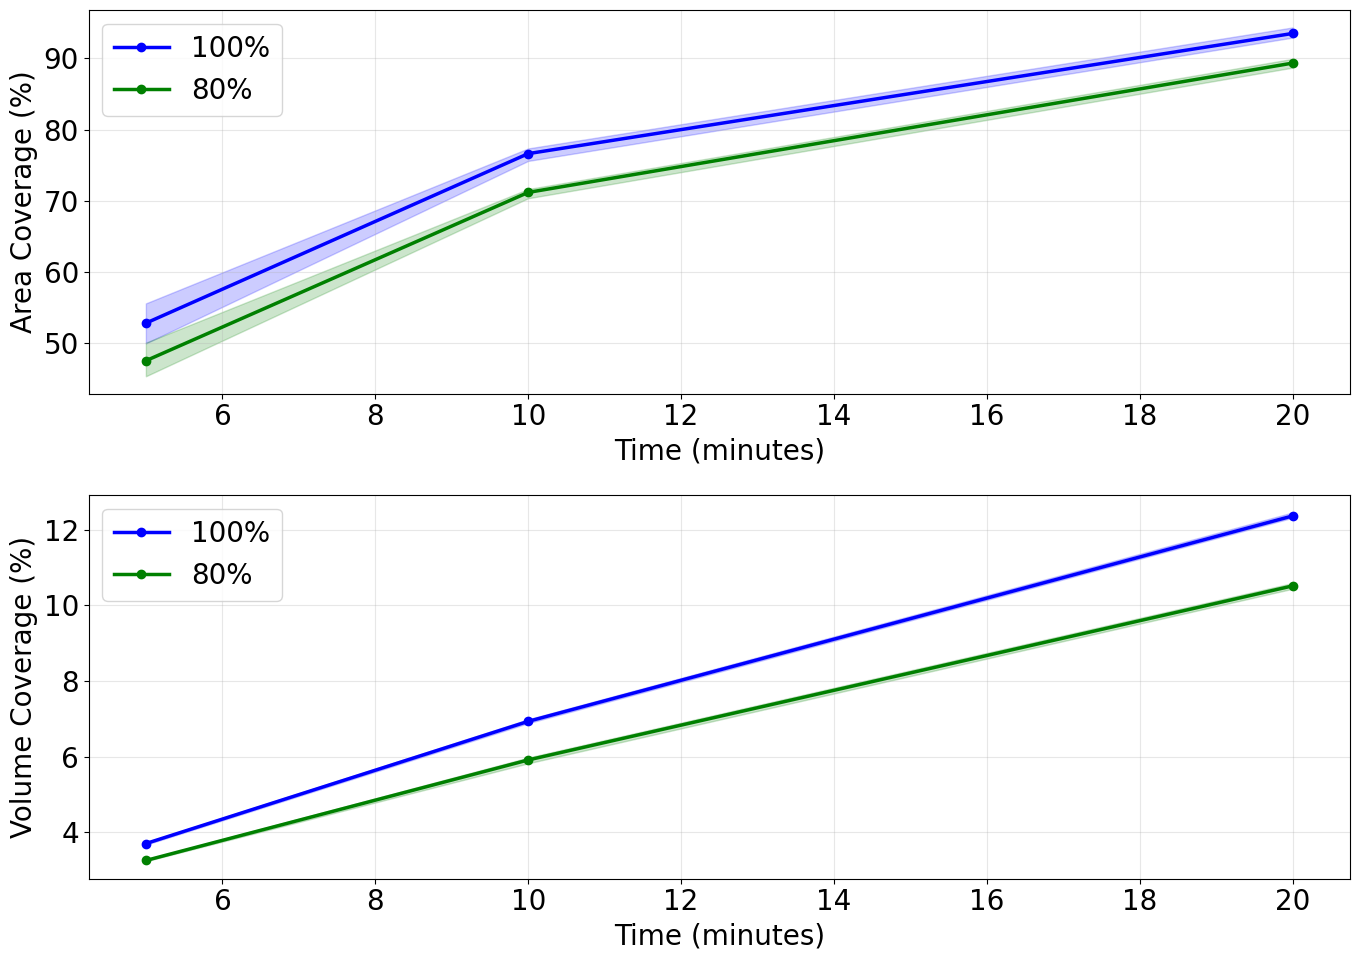

In [124]:
times = [5.0, 10.0, 20.0]
cov = [cov_100[:3], cov_80[:3], cov_100[6:9], cov_80[6:9]]
cov_iqr = [iqr_cov_100[:3], iqr_cov_80[:3], iqr_cov_100[6:9], iqr_cov_80[6:9]]
cov_labels = ['100%', '80%']
colors = ['b', 'g', 'r', 'orange']

for i in range(len(cov)):
    if i < 2:
        plt.subplot(2,1,1)
    else:
        plt.subplot(2,1,2)
    # Plot main line
    plt.plot(times, cov[i], color=colors[i%2], linewidth=2.5, 
            label=cov_labels[i%2], marker='o', markersize=6)
    plt.fill_between(times, 
                   cov_iqr[i][:,0], 
                   cov_iqr[i][:,1], 
                   color=colors[i%2], alpha=0.2)

plt.subplot(2,1,1)
plt.xlabel('Time (minutes)')
plt.ylabel('Area Coverage (%)')
#ax.set_title('Neural Decoder Performance: MSE vs Gain Settings', fontsize=14, fontweight='bold')
#ax.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Time (minutes)')
plt.ylabel('Volume Coverage (%)')
#ax.set_title('Neural Decoder Performance: MSE vs Gain Settings', fontsize=14, fontweight='bold')
#ax.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('TimeDimensionComparison.png', format='png')
plt.show()

# Plot the results

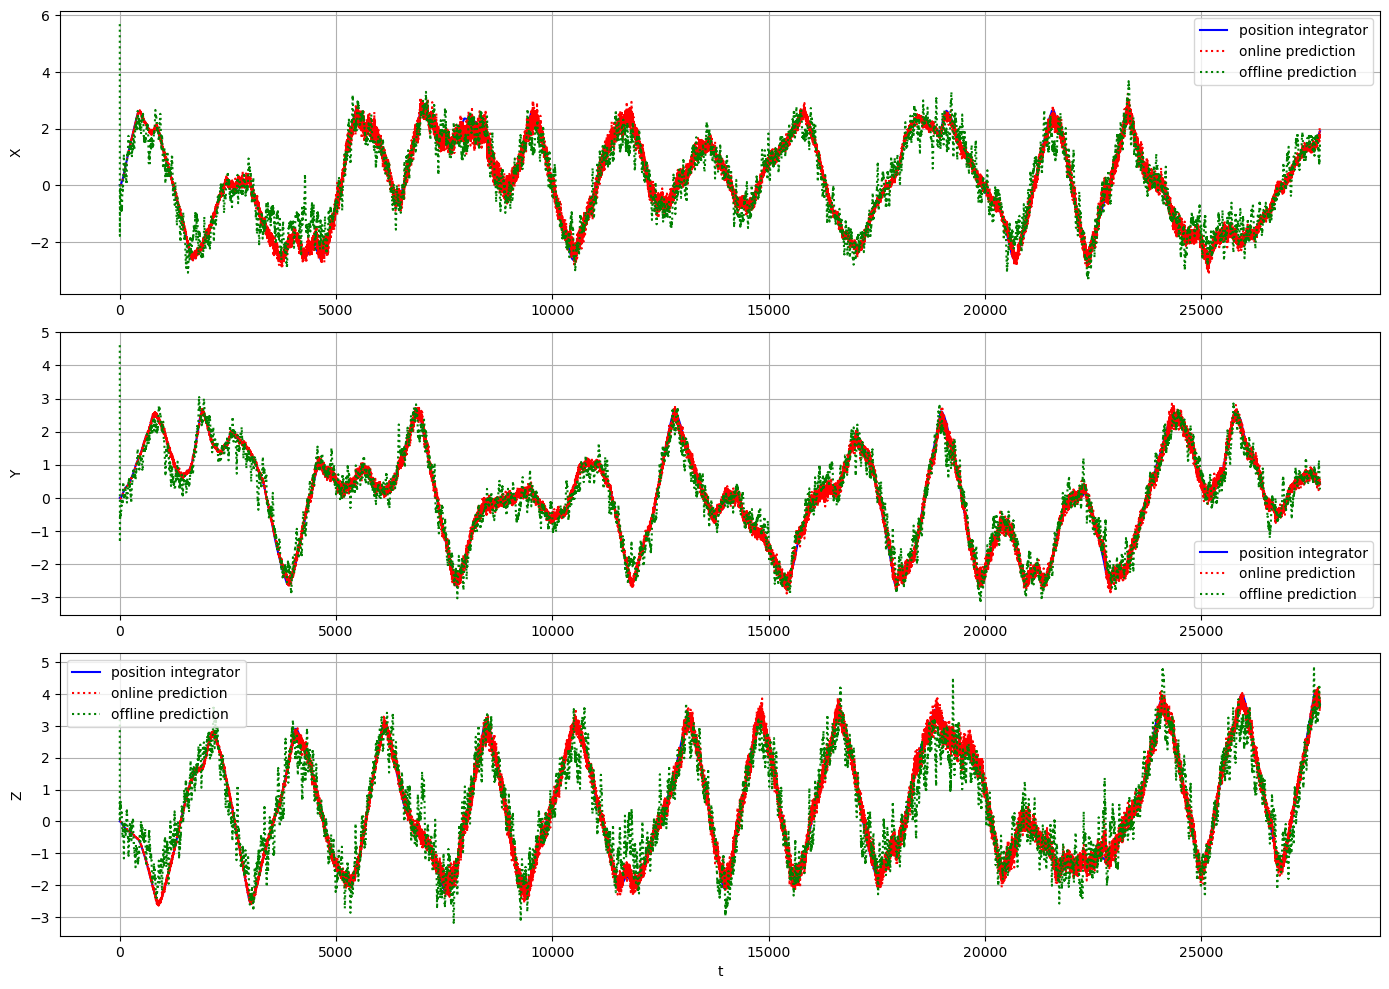

In [20]:
XYZoverTime(pos_i, pos_p, y_pred, [ 'position integrator', 'online prediction', 'offline prediction'], ['b-', 'r:', 'g:'])

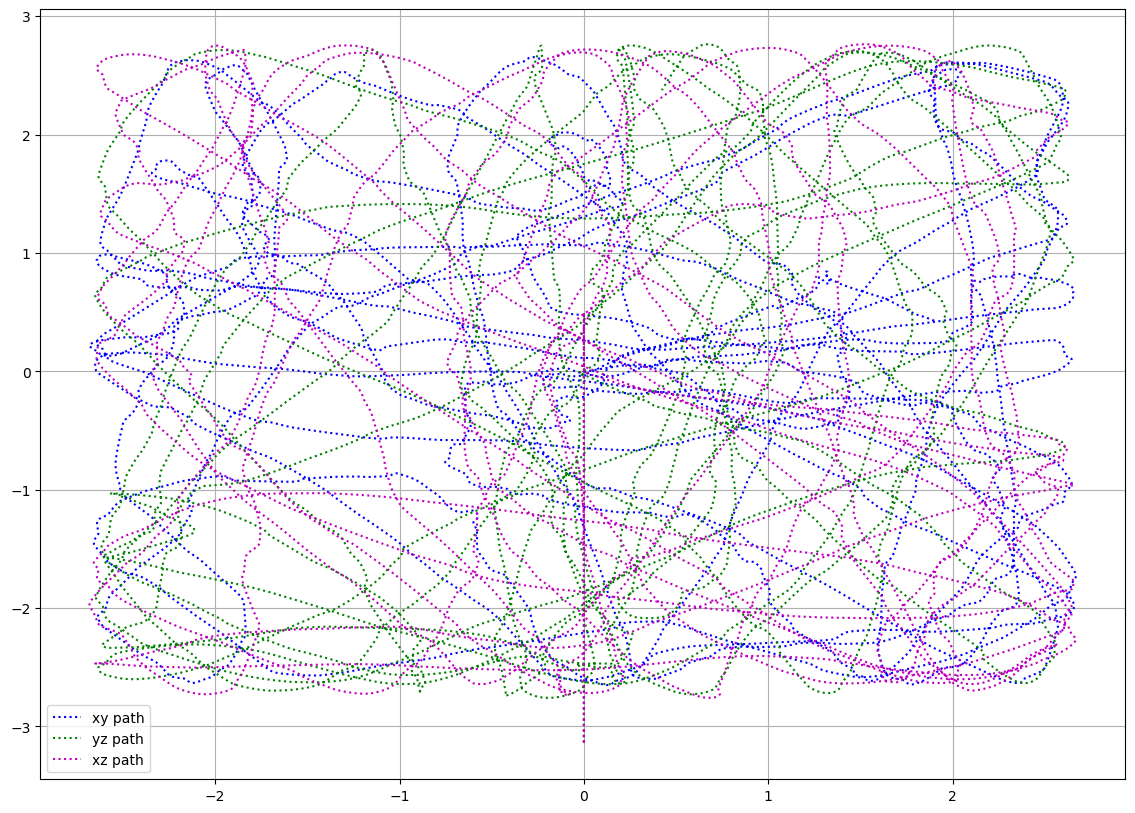

In [54]:
x, y, z = pos_r[:,0], pos_r[:,1], pos_r[:,2]
plt.plot(x, y, 'b:', label='xy path')
plt.plot(y, z, 'g:', label='yz path')
plt.plot(x, z, 'm:', label='xz path')
plt.grid()
plt.legend()
plt.show()

In [18]:
plot_3d_trajectory(pos_r, boundaries, ID=ID)

NameError: name 'plot_3d_trajectory' is not defined

In [ ]:
plot_prediction_path_3d(pos_r, pos_i, pos_r, np.mean(mse_ar), ID=ID)
prediction_path_projected(pos_i, pos_p, mse_ar, ID=ID)
plot_modular_activity(projection_operator, pos_i, activity, gains, ID, projection)

## Plot Trajectory 

In [ ]:
def plot_3d_trajectory(pos, boundaries, ID='null'):
    x, y, z = pos[:,0], pos[:,1], pos[:,2]
    
    start = 0
    stop = int(len(x))#/5)
    #stop = np.clip(stop, 10, 40000)

    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(x[:stop], y[:stop], z[:stop], label='path')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    #plt.show()
    plt.savefig(f'Results\\ID {ID}\\3d_trajectory_spaceplot.png', format='png')
   # plt.close()

## Plot Prediction Path

In [ ]:
def plot_prediction_path_3d(path, path_in, path_pred, mse_mean, ID=0):
    stop = int(len(path)/5)
    stop = np.clip(stop, 10, 40000)
    # Unpack the actual and predicted coordinates
    x, y, z = path[:, 0], path[:, 1], path[:, 2]
    x_i, y_i, z_i = path_in[:, 0], path_in[:, 1], path_in[:, 2]
    x_pred, y_pred_val, z_pred = path_pred[:, 0], path_pred[:, 1], path_pred[:, 2]

    # Create a new figure and 3D axis
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the actual and predicted paths
    ax.plot(x[:stop], y[:stop], z[:stop], label='Actual path', color='blue')
    ax.plot(x_i[:stop], y_i[:stop], z_i[:stop], 'g:', label='path integrator')
    ax.plot(x_pred[:stop], y_pred_val[:stop], z_pred[:stop], 'r,', label='Predicted path')
    
    # Label axes, legend, and set title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title(f'Last {stop} iterations. Mean MSE = {mse_mean}')

    # End of simu
    plt.tight_layout()
    # Save and show the figure
    plt.savefig(f'Results\\ID {ID}\\predictionF.png', format='png')
    #plt.show()
    #plt.close()

    # Create a new figure and 3D axis
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the actual and predicted paths
    ax.plot(x[-stop:], y[-stop:], z[-stop:], label='Actual path', color='blue')
    ax.plot(x_i[-stop:], y_i[-stop:], z_i[-stop:], 'g:', label='path integrator')
    ax.plot(x_pred[-stop:], y_pred_val[-stop:], z_pred[-stop:], 'r,', label='Predicted path')
    
    # Label axes, legend, and set title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title(f'Last {stop} iterations. Mean MSE = {mse_mean}')

    plt.tight_layout()
    # Save and show the figure
    plt.savefig(f'Results\\ID {ID}\\predictionL.png', format='png')
    #plt.show()
    #plt.close()

def prediction_path_projected(path, path_pred, mse, ID=0):
    stop = int(len(path)/5)
    #stop = np.clip(stop, 10, 40000)
    
    x, y, z = path[:,0], path[:,1], path[:,2] 
    x_pred, y_pred, z_pred = path_pred[:,0], path_pred[:,1], path_pred[:,2] 
    x_min, y_min, z_min = np.min(x), np.max(y), np.min(z) # the y-axis is weird like that

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot x and y axes on z.
    ax.plot(x[:stop], y[:stop], 'b-', zs=z_min, zdir='z', label='path in (x, y)')
    ax.plot(x_pred[:stop], y_pred[:stop], 'c,', zs=z_min, zdir='z', label='prediction in (x, y)')
    
    ax.plot(x[:stop], z[:stop], 'r-', zs=y_min, zdir='y', label='path in (x, z)')
    ax.plot(x_pred[:stop], z_pred[:stop], 'm,' ,zs=y_min, zdir='y', label='prediction in (x, z)')
    
    ax.plot(y[:stop], z[:stop], 'g-', zs=x_min, zdir='x', label='path in (y, z)')
    ax.plot(y_pred[:stop], z_pred[:stop], 'y,', zs=x_min, zdir='x', label='prediction in (y, z)')

    # Make legend, set axes limits and labels
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Integrated vs Predicted Path. First {stop} iterations. Mean MSE = {np.mean(mse)}')
    
    # Customize the view angle so it's easier to see that the scatter points lie
    # on the plane y=0
    #ax.view_init(elev=20., azim=-35, roll=0)
    plt.tight_layout()
    # Save and show the figure
    plt.show()
    plt.savefig(f'Results\\ID {ID}\\predictionProjected.png', format='png')
    plt.close()

## Plot Neural Activity

## Produce Plots

In [114]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')

def visualize_neural_activity_3d(position, activity, neuron_idx, bins=50, alpha=0.7, 
                                figsize=(12, 10), colormap='viridis'):
    """
    Visualize neural activity from 3 distinct 2D neural networks that encode 
    projections of 3D spatial positions.
    
    Parameters:
    -----------
    position : np.ndarray
        Shape (time, 3) - 3D position of object/agent over time (X, Y, Z)
    activity : np.ndarray
        Shape (time, module, gain, neuron) - Neural activity data
        module: 0=XY, 1=YZ, 2=XZ projections
    neuron_idx : int
        Index of the neuron to visualize
    bins : int
        Number of bins for heatmap generation (default: 50)
    alpha : float
        Transparency of heatmaps (default: 0.7)
    figsize : tuple
        Figure size (default: (12, 10))
    colormap : str
        Colormap for heatmaps (default: 'viridis')
    
    Returns:
    --------
    list : List of matplotlib figure objects (one per gain)
    """
    
    # Validate inputs
    if position.shape[1] != 3:
        raise ValueError("Position array must have shape (time, 3)")
    
    if len(activity.shape) != 4:
        raise ValueError("Activity array must have shape (time, module, gain, neuron)")
    
    if activity.shape[0] != position.shape[0]:
        raise ValueError("Position and activity must have same time dimension")
    
    if activity.shape[1] != 3:
        raise ValueError("Activity must have exactly 3 modules (XY, YZ, XZ)")
    
    if neuron_idx >= activity.shape[3]:
        raise ValueError(f"neuron_idx {neuron_idx} exceeds available neurons {activity.shape[3]}")
    
    time_steps, n_modules, n_gains, n_neurons = activity.shape
    figures = []
    
    # Extract position coordinates
    x_pos, y_pos, z_pos = position[:, 0], position[:, 1], position[:, 2]
    
    # Define projections
    projections = {
        0: {'coords': (x_pos, y_pos), 'labels': ('X', 'Y'), 'plane': 'XY'},
        1: {'coords': (y_pos, z_pos), 'labels': ('Y', 'Z'), 'plane': 'YZ'},
        2: {'coords': (x_pos, z_pos), 'labels': ('X', 'Z'), 'plane': 'XZ'}
    }
    
    # Calculate overall position ranges for consistent scaling
    x_range = [x_pos.min(), x_pos.max()]
    y_range = [y_pos.min(), y_pos.max()]
    z_range = [z_pos.min(), z_pos.max()]
    
    # Generate one plot per gain
    for gain_idx in range(n_gains):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        
        # Process each module (projection plane)
        for module_idx in range(n_modules):
            # Get neural activity for this module, gain, and neuron
            neural_activity = activity[:, module_idx, gain_idx, neuron_idx]
            
            # Get 2D coordinates for this projection
            coords = projections[module_idx]['coords']
            x_proj, y_proj = coords[0], coords[1]
            
            # Create 2D histogram/heatmap
            # Filter out invalid data points
            valid_mask = ~(np.isnan(x_proj) | np.isnan(y_proj) | np.isnan(neural_activity))
            if not np.any(valid_mask):
                continue
                
            x_valid = x_proj[valid_mask]
            y_valid = y_proj[valid_mask]
            activity_valid = neural_activity[valid_mask]
            
            # Create grid for interpolation
            x_grid = np.linspace(x_valid.min(), x_valid.max(), bins)
            y_grid = np.linspace(y_valid.min(), y_valid.max(), bins)
            X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
            
            # Interpolate activity values onto grid
            try:
                # Use griddata for smooth interpolation
                Z_grid = griddata((x_valid, y_valid), activity_valid, 
                                (X_grid, Y_grid), method='cubic', fill_value=0)
                
                # Handle NaN values
                Z_grid = np.nan_to_num(Z_grid, nan=0.0)
                
            except Exception:
                # Fallback to simple 2D histogram if interpolation fails
                H, x_edges, y_edges = np.histogram2d(x_valid, y_valid, 
                                                   weights=activity_valid, bins=bins)
                X_grid, Y_grid = np.meshgrid(x_edges[:-1], y_edges[:-1])
                Z_grid = H.T
            
            # Position heatmap in 3D space based on projection plane
            if module_idx == 0:  # XY plane
                # Place at middle Z value
                z_plane = (z_range[0] + z_range[1]) / 2
                ax.contourf(X_grid, Y_grid, Z_grid, zdir='z', offset=z_plane, 
                          levels=20, alpha=alpha, cmap=colormap)
                
            elif module_idx == 1:  # YZ plane  
                # Place at middle X value
                x_plane = (x_range[0] + x_range[1]) / 2
                ax.contourf(Z_grid, X_grid, Y_grid, zdir='x', offset=x_plane,
                          levels=20, alpha=alpha, cmap=colormap)
                
            elif module_idx == 2:  # XZ plane
                # Place at middle Y value  
                y_plane = (y_range[0] + y_range[1]) / 2
                ax.contourf(X_grid, Z_grid, Y_grid, zdir='y', offset=y_plane,
                          levels=20, alpha=alpha, cmap=colormap)
        
        # Set labels and title
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position') 
        ax.set_zlabel('Z Position')
        ax.set_title(f'Neural Activity Visualization - Gain {gain_idx}, Neuron {neuron_idx}')
        
        # Set consistent axis limits
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        ax.set_zlim(z_range)
        
        # Add colorbar
        mappable = plt.cm.ScalarMappable(cmap=colormap)
        mappable.set_array([])
        cbar = plt.colorbar(mappable, ax=ax, shrink=0.5, aspect=20)
        cbar.set_label('Neural Activity')
        
        # Improve layout
        plt.tight_layout()
        figures.append(fig)
    
    return figures